In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.dates as mdates
from scipy.stats import shapiro

import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
original_data = pd.read_csv(filepath_or_buffer='SPCS20RPSNSA.csv', index_col='observation_date', parse_dates=True)
original_data.tail()

,SPCS20RPSNSA
observation_date,
2024-12-01,93822
2025-01-01,81549
2025-02-01,78228
2025-03-01,81755
2025-04-01,95416


In [3]:
original_data.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', name='observation_date', length=304, freq=None)

In [4]:
def plot_data_properties(data, ts_plot_name="Time Series Plot"):

    sns.set_style("whitegrid")

    # --- Time Series Plot ---
    plt.figure(figsize=(18, 4))
    plt.plot(data, color='royalblue', linewidth=2)
    plt.title(ts_plot_name, fontsize=16, fontweight='bold')
    plt.ylabel('Sales', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- ACF, PACF, Distribution ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), squeeze=False)

    plot_acf(data, ax=axes[0, 0], lags=48, title="Autocorrelation (ACF)")
    plot_pacf(data, ax=axes[0, 1], lags=48, title="Partial Autocorrelation (PACF)")

    sns.histplot(data, kde=True, ax=axes[0, 2], color='mediumseagreen', bins=30, legend=False)
    axes[0, 2].set_title("Probability Distribution", fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Sales')
    axes[0, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

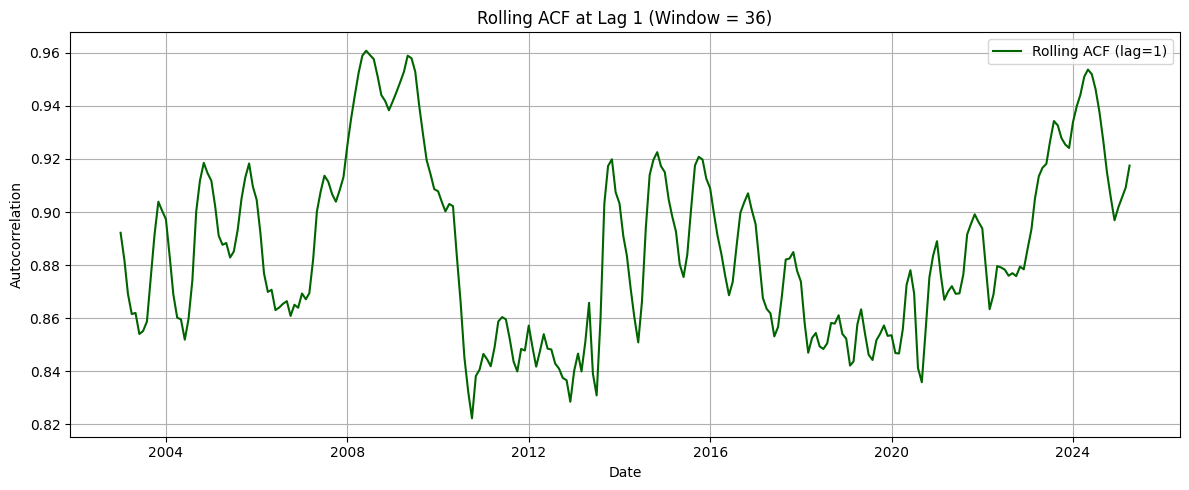

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


series = original_data['SPCS20RPSNSA']

# Set rolling window size
window_size = 36  # 3 years, assuming monthly data

# Compute rolling autocorrelation at lag 1
rolling_acf_lag1 = []
for i in range(window_size, len(series)):
    window = series[i - window_size:i]
    if window.isnull().any():
        rolling_acf_lag1.append(np.nan)
    else:
        acf_val = window.autocorr(lag=1)
        rolling_acf_lag1.append(acf_val)

# Create index and DataFrame
acf_index = series.index[window_size:]
rolling_acf_df = pd.DataFrame({
    'date': acf_index,
    'rolling_acf_lag1': rolling_acf_lag1
}).set_index('date')

# Plot the rolling ACF at lag 1
plt.figure(figsize=(12, 5))
plt.plot(rolling_acf_df.index, rolling_acf_df['rolling_acf_lag1'], color='darkgreen', label='Rolling ACF (lag=1)')
plt.title('Rolling ACF at Lag 1 (Window = 36)')
plt.xlabel('Date')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Rolling ACF Shows:
How autocorrelation (lag relationships) change over time

Whether the dependence structure is stable

If the series violates the assumption of stationarity

🔍 What You Learn from It:
Pattern in Rolling ACF	What It Means
ACF stays roughly constant over time	✅ Likely stationary autocorrelation structure
ACF trends upward/downward or fluctuates wildly	❌ Non-stationary — time series structure is changing
Spikes during certain periods	🔄 Possible regime shifts, seasonality, or structural breaks.

###################################################################################################################

What the Rolling ACF Plot Shows:
Fluctuations in autocorrelation over time (ranging roughly from ~0.82 to ~0.96).

Noticeable dips and peaks, especially:

Around 2008–2011, there's a sudden drop and then relatively low/stable ACF.

After 2020, ACF starts rising again.

🧠 Conclusion: The Autocorrelation Structure Is Not Constant
This violates the third assumption of weak stationarity.

Evidence	Interpretation
ACF at lag 1 changes significantly over time	➤ The time series has time-varying autocorrelation, i.e., non-stationary structure.
Long periods of rising or falling ACF	➤ Possibly reflects regime shifts, policy changes, or external shocks (e.g., 2008 crash, 2020 pandemic)

##############################################################################################################################

hy Do We Use ACF at Lag 1?
✅ 1. Lag 1 is the most immediate memory of a time series
It tells you how strongly today’s value is related to yesterday’s (or previous time step).

If this correlation is strong and stable, it often means the series has short-term dependence, which many models (like AR, ARIMA) exploit.

✅ 2. First place to check for non-stationarity
In a non-stationary series, the ACF at lag 1 is typically very high (close to 1), and doesn't decay quickly.

Watching how ACF at lag 1 changes over time helps you detect time-varying dependence — i.e., when the time series structure is changing.

✅ 3. Fast, interpretable diagnostic
Rolling ACF at lag 1 is:

Easy to compute

Fast to visualize

Easy to interpret: high values mean strong correlation with the previous time step

🔬 What If You Want More?
You can compute rolling ACF at multiple lags (lag 2, lag 12, etc.) depending on your use case.

For example:

Lag 12 might be useful if your data is monthly and you suspect seasonality.

A full ACF plot over a rolling window (not just one lag) can reveal deeper structures.

##################################################################################################

Why Use a 36-Month (3-Year) Rolling Window?
✅ 1. Balance Between Stability and Sensitivity
A rolling window needs to be long enough to compute reliable statistics (like autocorrelation).

But it shouldn't be so long that it hides structural changes.

36 months (3 years) is often a good middle ground:

Long enough to get meaningful autocorrelation

Short enough to detect medium-term changes in structure

✅ 2. Seasonality Consideration (Monthly Data)
Your data is monthly, and housing or economic time series often show yearly patterns.

So:

12 months = 1 cycle

36 months = 3 full seasonal cycles
This makes the window better at smoothing out noise and capturing underlying trends or shifts.

✅ 3. Standard Practice in Economics and Finance
In housing, macroeconomic, or financial time series, rolling statistics over 36 months are commonly used to:

Analyze economic cycles

Track medium-term trends

Smooth out temporary fluctuations


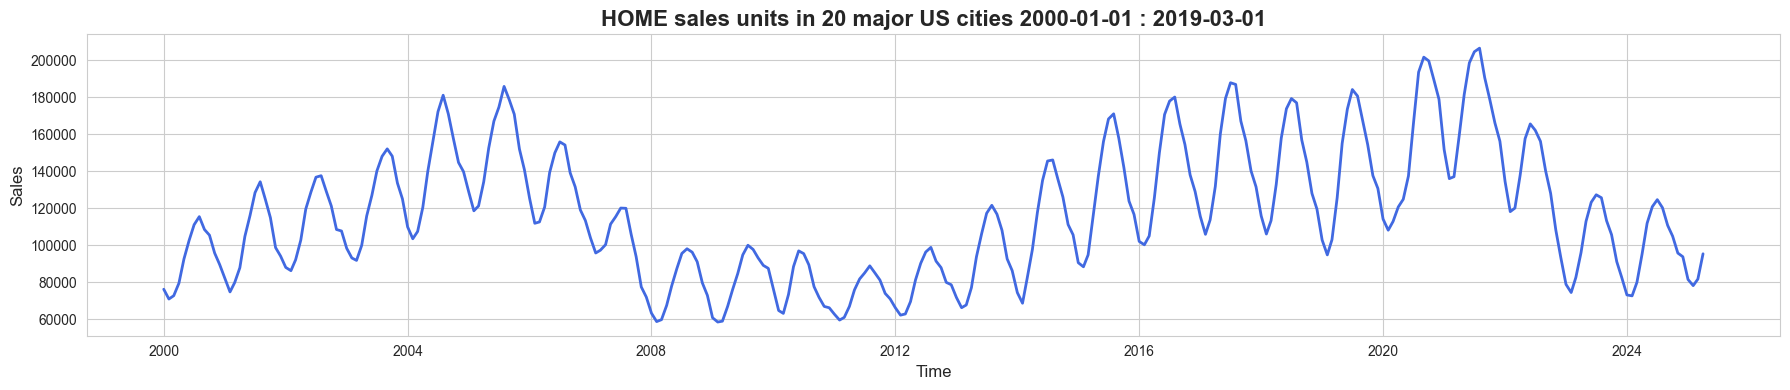

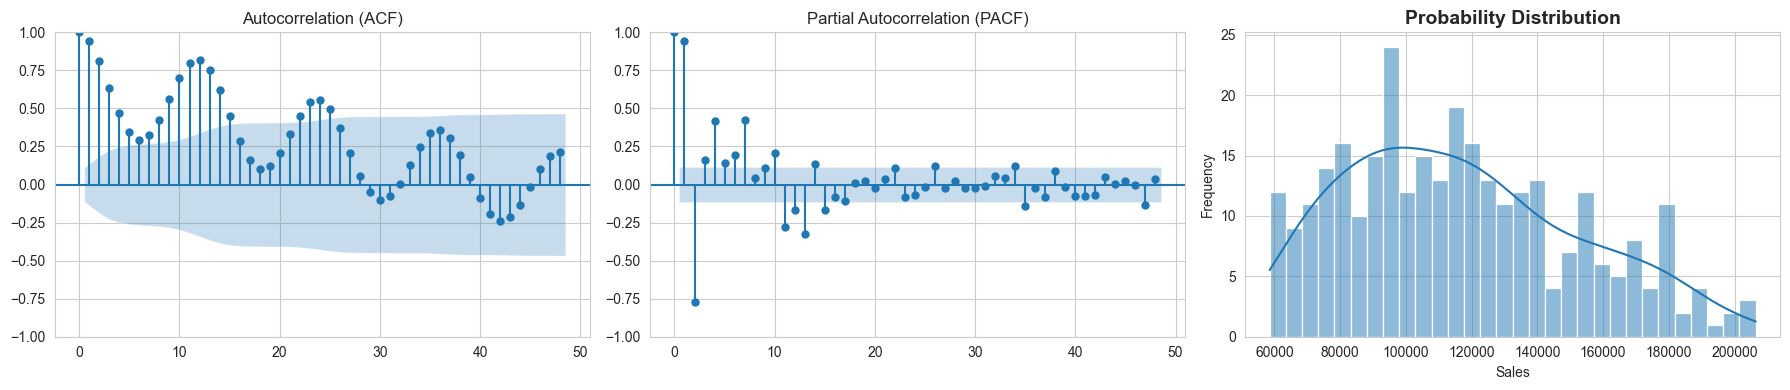

In [6]:
plot_data_properties(original_data, 'HOME sales units in 20 major US cities 2000-01-01 : 2019-03-01');

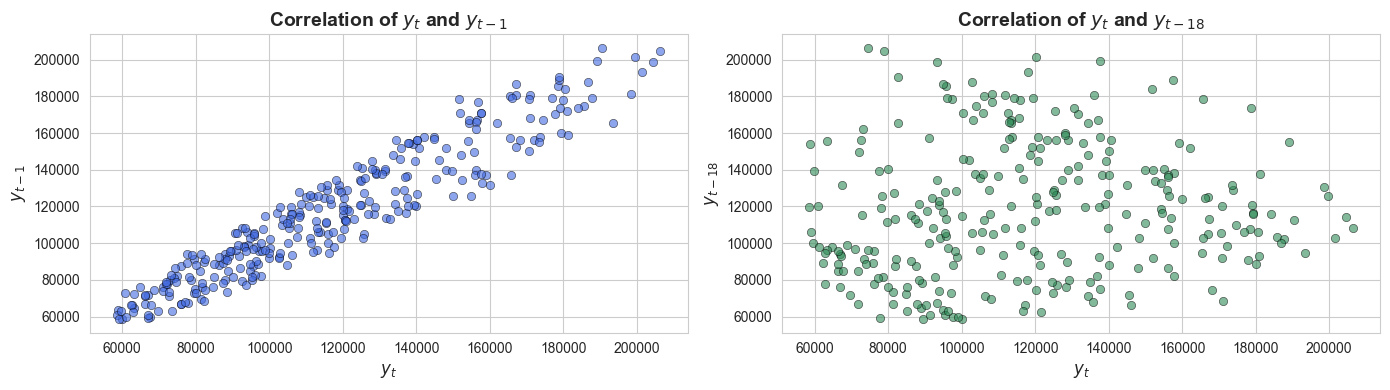

In [7]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 4), squeeze=False)

axes[0, 0].scatter(
    x=original_data[1:], 
    y=original_data.shift(1)[1:], 
    alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5, 
    color='royalblue'
)
    
axes[0, 0].set_title('Correlation of $y_t$ and $y_{t-1}$', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('$y_t$', fontsize=12)
axes[0, 0].set_ylabel('$y_{t-1}$', fontsize=12)
axes[0, 0].grid(True)

axes[0, 1].scatter(
    x=original_data[18:], 
    y=original_data.shift(18)[18:], 
    alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5, 
    color='seagreen'
)

axes[0, 1].set_title('Correlation of $y_t$ and $y_{t-18}$', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('$y_t$', fontsize=12)
axes[0, 1].set_ylabel('$y_{t-18}$', fontsize=12)
axes[0, 1].grid(True)

plt.tight_layout()
plt.show()

 Interpretation:
🔹 Left Plot (Lag 1 Correlation):
Strong positive linear correlation — points tightly clustered around a diagonal line.

This shows strong short-term dependence — each value is highly dependent on the previous one.

It’s also a signal of non-stationarity, since such strong correlation is typical in trending or non-stationary series.

🔹 Right Plot (Lag 18 Correlation):
Scattered points with no clear pattern.

This suggests that lag 18 has little to no predictive power for yₜ.

It also implies no seasonal pattern at a lag of 18 months — often tested in monthly time series for seasonality (~12, 24, etc.).

📌 What You Can Conclude:
Observation	Conclusion
Strong correlation at lag 1	➤ Likely non-stationary; strong autocorrelation
Weak/no correlation at lag 18	➤ No seasonality at 18 months, and short memory process

In [8]:
original_data.columns


Index(['SPCS20RPSNSA'], dtype='object')

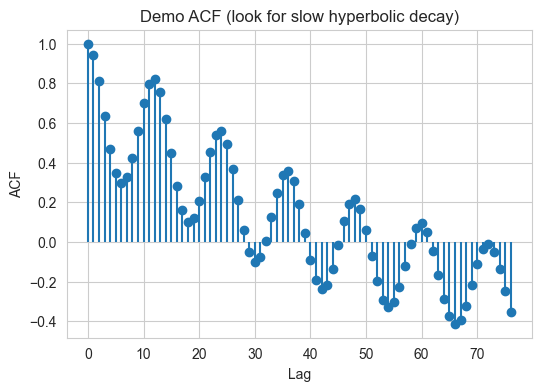

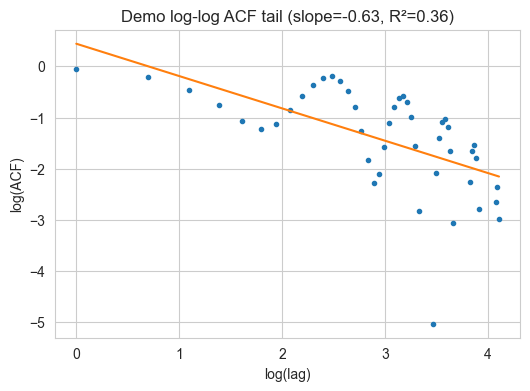

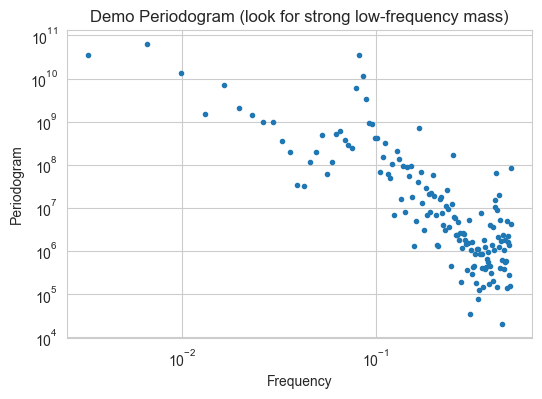

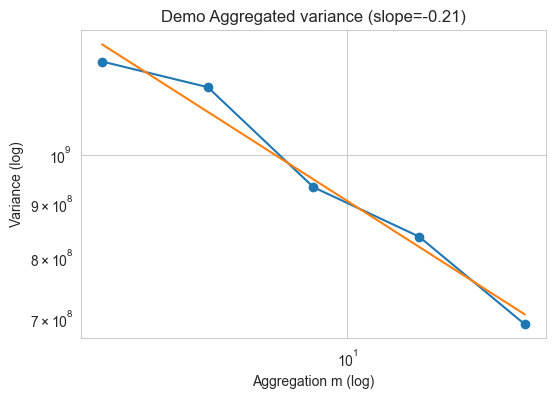

GPH d̂ = 0.269 (SE ~ 0.035)
Hurst (R/S) H ≈ 0.922
DFA α ≈ 1.000
ADF: stat=-2.799, p=0.058  (H0: unit root)
KPSS: stat=0.489, p=0.044  (H0: stationary)
Ljung-Box(20): Q=1919.13, p=0.000
Recommendation: Stationary long-memory (0 < d < 0.5): ARFIMA(p,d,q) is appropriate; include short-run ARMA terms as needed.
Notes: Strong long-memory signal (d > 0.2).
{'d': np.float64(0.2687281431978383), 'd_se': np.float64(0.03517437891818288), 'H': np.float64(0.9222243487861413), 'alpha': np.float64(0.9997324548404456), 'recommendation': 'Stationary long-memory (0 < d < 0.5): ARFIMA(p,d,q) is appropriate; include short-run ARMA terms as needed.', 'notes': ['Strong long-memory signal (d > 0.2).']}


In [9]:
# --- Long vs Short Memory Diagnostics (no fracdiff) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# -----------------------------
# 1) VISUAL CHECKS
# -----------------------------
def visual_checks(y, max_lag=200, agg_scales=(2,4,8,16,32), show=True, title_prefix=""):
    """
    Visual diagnostics:
      - ACF tail (hyperbolic vs exponential)
      - Log-Log ACF tail (slope ~ long memory if slope close to -alpha with small curvature)
      - Periodogram with low-frequency emphasis
      - Aggregated variance decay (slower than 1/m suggests long memory)
    """
    y = pd.Series(y).dropna().astype(float).values
    y = y - np.nanmean(y)
    n = len(y)
    lags = min(max_lag, n//4)

    # ACF
    acf_vals = acf(y, nlags=lags, fft=True)
    lag_idx = np.arange(len(acf_vals))

    # Periodogram
    freqs = np.fft.rfftfreq(n, d=1.0)[1:]  # skip zero freq
    spec = (np.abs(np.fft.rfft(y)[1:])**2) / n

    # Aggregated variance test
    agg_var = []
    for m in agg_scales:
        k = n // m
        if k < 2: 
            agg_var.append(np.nan)
            continue
        y_trim = y[:k*m].reshape(k, m).mean(axis=1)  # average in blocks of size m
        agg_var.append(np.var(y_trim, ddof=1))

    # Plots
    if show:
        plt.figure(figsize=(6,4))
        plt.stem(lag_idx, acf_vals, basefmt=" ")
        plt.xlabel("Lag"); plt.ylabel("ACF")
        plt.title(f"{title_prefix} ACF (look for slow hyperbolic decay)"); plt.show()

        # Log-Log ACF tail (ignore lag 0)
        valid = (lag_idx[1:] > 0) & (acf_vals[1:] > 0)
        if valid.sum() >= 10:
            plt.figure(figsize=(6,4))
            plt.plot(np.log(lag_idx[1:][valid]), np.log(acf_vals[1:][valid]), '.')
            slope, intercept, r, p, se = stats.linregress(np.log(lag_idx[1:][valid]), np.log(acf_vals[1:][valid]))
            plt.plot(np.log(lag_idx[1:][valid]),
                     intercept + slope*np.log(lag_idx[1:][valid]))
            plt.xlabel("log(lag)"); plt.ylabel("log(ACF)")
            plt.title(f"{title_prefix} log-log ACF tail (slope={slope:.2f}, R²={r**2:.2f})")
            plt.show()
        else:
            print("log-log ACF: insufficient positive ACF tail to fit.")

        # Periodogram (emphasize low freq)
        plt.figure(figsize=(6,4))
        plt.loglog(freqs, spec, '.')
        plt.xlabel("Frequency"); plt.ylabel("Periodogram")
        plt.title(f"{title_prefix} Periodogram (look for strong low-frequency mass)")
        plt.show()

        # Aggregated variance decay
        plt.figure(figsize=(6,4))
        valid_m = np.array([m for m,v in zip(agg_scales, agg_var) if np.isfinite(v)])
        valid_var = np.array([v for v in agg_var if np.isfinite(v)])
        if len(valid_m) >= 2:
            plt.loglog(valid_m, valid_var, '-o')
            slope, intercept, r, p, se = stats.linregress(np.log(valid_m), np.log(valid_var))
            plt.plot(valid_m, np.exp(intercept)*valid_m**slope)
            plt.title(f"{title_prefix} Aggregated variance (slope={slope:.2f})")
            plt.xlabel("Aggregation m (log)"); plt.ylabel("Variance (log)")
            plt.show()
        else:
            print("Aggregation variance: not enough points to assess.")

    return {
        "acf": acf_vals,
        "periodogram_freqs": freqs,
        "periodogram_spec": spec,
        "agg_scales": agg_scales,
        "agg_variance": agg_var
    }

# -----------------------------
# 2) HURST EXPONENT (R/S)
# -----------------------------
def hurst_rs(y, min_window=8):
    """
    Classic R/S Hurst estimator (simple, robust, no external packages).
    H ~ 0.5 short memory; H>0.5 persistent; H<0.5 anti-persistent.
    """
    x = pd.Series(y).dropna().astype(float).values
    n = len(x)
    if n < 2*min_window:
        raise ValueError("Series too short for R/S.")

    # Choose window sizes roughly logarithmically spaced
    windows = np.unique((np.exp(np.linspace(np.log(min_window), np.log(n//2), 20))).astype(int))
    RS = []
    scales = []
    for w in windows:
        if w < min_window: 
            continue
        k = n // w
        if k < 2:
            continue
        segs = x[:k*w].reshape(k, w)
        rs_vals = []
        for seg in segs:
            seg = seg - seg.mean()
            ycum = np.cumsum(seg)
            R = ycum.max() - ycum.min()
            S = seg.std(ddof=1)
            if S > 0:
                rs_vals.append(R / S)
        if len(rs_vals) > 0:
            RS.append(np.mean(rs_vals))
            scales.append(w)

    scales = np.array(scales)
    RS = np.array(RS)
    slope, intercept, r, p, se = stats.linregress(np.log(scales), np.log(RS))
    H = slope  # in R/S, slope ~ H
    return {"H": H, "scales": scales, "RS": RS, "R2": r**2}

# -----------------------------
# 3) DFA (Detrended Fluctuation Analysis)
# -----------------------------
def dfa_alpha(y, min_window=8):
    """
    Simple DFA(1) estimator. Alpha ~ 0.5 for white noise;
    Alpha in (0.5,1) persistent; ~1.5 for random walk (integrated).
    For stationary long memory, d ≈ Alpha - 0.5 (rough heuristic).
    """
    x = pd.Series(y).dropna().astype(float).values
    x = x - np.mean(x)
    ycum = np.cumsum(x)  # profile

    n = len(x)
    if n < 4*min_window:
        raise ValueError("Series too short for DFA.")

    # window sizes
    s_vals = np.unique((np.exp(np.linspace(np.log(min_window), np.log(n//4), 20))).astype(int))
    F = []
    S = []
    for s in s_vals:
        k = n // s
        if k < 2: 
            continue
        # detrend each segment via OLS on index
        rms = []
        for i in range(k):
            seg = ycum[i*s:(i+1)*s]
            t = np.arange(s)
            # linear fit
            A = np.vstack([t, np.ones(s)]).T
            a, b = np.linalg.lstsq(A, seg, rcond=None)[0]
            trend = a*t + b
            rms.append(np.sqrt(np.mean((seg - trend)**2)))
        F.append(np.mean(rms))
        S.append(s)

    S = np.array(S); F = np.array(F)
    slope, intercept, r, p, se = stats.linregress(np.log(S), np.log(F))
    alpha = slope
    return {"alpha": alpha, "scales": S, "F": F, "R2": r**2}

# -----------------------------
# 4) GPH (Geweke–Porter–Hudak) estimator for d
# -----------------------------
def gph_d(y, m=None):
    """
    Log-periodogram regression estimator for fractional differencing d.
    Regress log I(lambda_j) on log(4 sin^2(lambda_j/2)) for low j=1..m.
    Default m ~ n^0.6 (common choice).
    Returns d_hat and SE (large-sample).
    """
    x = pd.Series(y).dropna().astype(float).values
    n = len(x)
    x = x - x.mean()

    # periodogram
    fft = np.fft.rfft(x)
    I = (np.abs(fft)**2)/n
    lam = 2*np.pi*np.fft.rfftfreq(n, d=1.0)

    # drop zero frequency
    lam = lam[1:]
    I = I[1:]

    if m is None:
        m = int(n**0.6)
    m = max(5, min(m, len(lam)))

    lam_m = lam[:m]
    I_m = I[:m]

    Z = np.log(4*np.sin(lam_m/2.0)**2)
    Y = np.log(I_m)

    slope, intercept, r, p, se = stats.linregress(Z, Y)
    b = slope
    d_hat = -b / 2.0

    # Asymptotic SE for GPH slope: sqrt(pi^2 / (24 * sum((Z - Zbar)^2)))
    Zc = Z - Z.mean()
    se_b = np.sqrt((np.pi**2) / (24 * np.sum(Zc**2)))
    se_d = se_b / 2.0

    return {"d": d_hat, "se": se_d, "m": m, "R2": r**2}

# -----------------------------
# 5) Stationarity tests & summary + recommendation
# -----------------------------
def stationarity_tests(y):
    x = pd.Series(y).dropna().astype(float).values
    out = {}
    # ADF (H0: unit root / nonstationary)
    adf_stat, adf_p, _, _, crit, _ = adfuller(x, autolag='AIC')
    out["adf_stat"], out["adf_p"], out["adf_crit"] = adf_stat, adf_p, crit
    # KPSS (H0: stationary) - level
    try:
        kpss_stat, kpss_p, _, kpss_crit = kpss(x, regression='c', nlags="auto")
        out["kpss_stat"], out["kpss_p"], out["kpss_crit"] = kpss_stat, kpss_p, kpss_crit
    except Exception as e:
        out["kpss_error"] = str(e)
    # Ljung-Box on raw (quick check)
    lb = acorr_ljungbox(x, lags=[20], return_df=True)
    out["ljungbox_Q"], out["ljungbox_p"] = float(lb["lb_stat"].iloc[0]), float(lb["lb_pvalue"].iloc[0])
    return out

def recommend_model(y, verbose=True):
    H = hurst_rs(y)["H"]
    dfa = dfa_alpha(y)
    d_est = gph_d(y)

    d, d_se = d_est["d"], d_est["se"]
    alpha = dfa["alpha"]

    # Rough guide:
    # d in (-0.5, 0.5): stationary; d>0 implies long memory; d~0 short memory
    # H ≈ d + 0.5 for stationary fractional noise (heuristic)
    # alpha ≈ d + 0.5 (for stationary fractional noise)
    # thresholds below are pragmatic, not strict tests
    long_mem_flag = (d - 1.96*d_se) > 0.0  # significantly > 0
    strong_long_mem = d > 0.2
    anti_persist = (d + 1.96*d_se) < 0.0

    if verbose:
        print(f"GPH d̂ = {d:.3f} (SE ~ {d_se:.3f})")
        print(f"Hurst (R/S) H ≈ {H:.3f}")
        print(f"DFA α ≈ {alpha:.3f}")
        st = stationarity_tests(y)
        print(f"ADF: stat={st['adf_stat']:.3f}, p={st['adf_p']:.3f}  (H0: unit root)")
        if "kpss_p" in st:
            print(f"KPSS: stat={st['kpss_stat']:.3f}, p={st['kpss_p']:.3f}  (H0: stationary)")
        print(f"Ljung-Box(20): Q={st['ljungbox_Q']:.2f}, p={st['ljungbox_p']:.3f}")

    # Recommendation
    note = []
    if long_mem_flag:
        if d >= 0.5:
            rec = "Non-stationary long-memory (d ≥ 0.5): consider ARFIMA with d≥0.5 or fractional differencing to stationarity before ARMA."
        else:
            rec = "Stationary long-memory (0 < d < 0.5): ARFIMA(p,d,q) is appropriate; include short-run ARMA terms as needed."
        if strong_long_mem:
            note.append("Strong long-memory signal (d > 0.2).")
    elif anti_persist:
        rec = "Anti-persistent short memory (d < 0): ARMA/ARIMA may suffice; consider negative AR terms capturing mean reversion."
    else:
        rec = "No strong evidence of long memory (d ~ 0): use ARMA/ARIMA/SARIMA as appropriate."
    if verbose:
        print("Recommendation:", rec)
        if note: 
            print("Notes:", "; ".join(note))
    return {"d": d, "d_se": d_se, "H": H, "alpha": alpha, "recommendation": rec, "notes": note}

# -----------------------------
# 6) Example usage
# -----------------------------
if __name__ == "__main__":
    # Replace with your series (pd.Series or 1D array). Example: simulate ARFIMA-like signal for demo.
    y = pd.Series(
    original_data['SPCS20RPSNSA'].values,
    index=pd.date_range(start='2000-01-01', periods=len(original_data), freq='MS')
)




    # Or load your own:
    # y = pd.read_csv("my_series.csv")["value"].values

    _ = visual_checks(y, title_prefix="Demo")
    out = recommend_model(y)
    print(out)


#### from the above block of code , the series has long memory as depicted by Hurst expoenent an GPH d so we need fractional d and an arfima process

In [10]:
from statsmodels.tsa.seasonal import STL
import pandas as pd

def detect_seasonality(series, period):
    stl = STL(series, period=period, robust=True)
    result = stl.fit()

    seasonal_strength = 1 - (np.var(result.resid) / np.var(result.resid + result.seasonal))

    return {
        "Seasonal Strength": seasonal_strength,
        "Is Seasonal": seasonal_strength > 0.64  # rule-of-thumb threshold
    }
detect_seasonality(original_data['SPCS20RPSNSA'],12)

{'Seasonal Strength': np.float64(0.8847045853668963), 'Is Seasonal': np.True_}

In [11]:
from statsmodels.tsa.stattools import acf

def acf_seasonality_test(series, period, threshold=0.5):
    acf_vals = acf(series, nlags=period * 2)
    return {
        "ACF at lag {}".format(period): acf_vals[period],
        "Is Seasonal": abs(acf_vals[period]) > threshold
    }
acf_seasonality_test(original_data['SPCS20RPSNSA'],12)

{'ACF at lag 12': np.float64(0.8202780235498544), 'Is Seasonal': np.True_}

In [12]:
def check_seasonality_auto(series, period):
    stl_result = detect_seasonality(series, period)
    acf_result = acf_seasonality_test(series, period)
    if stl_result["Is Seasonal"] and acf_result["Is Seasonal"]:
        final = True
        confidence = "High"
    elif stl_result["Is Seasonal"] or acf_result["Is Seasonal"]:
        final = True
        confidence = "Moderate"
    else:
        final = False
        confidence = "Low"


    return {
    "STL Strength": stl_result["Seasonal Strength"],
    "ACF Score": acf_result["ACF at lag {}".format(period)],
    "STL Verdict": stl_result["Is Seasonal"],
    "ACF Verdict": acf_result["Is Seasonal"],
    "Final Verdict": final,
    "Confidence Level": confidence
}

series = original_data['SPCS20RPSNSA']
log_series = np.log(series)

seasonality = check_seasonality_auto(log_series, period=12)  # 12 = monthly → yearly
for k, v in seasonality.items():
    print(f"{k}: {v}")


STL Strength: 0.8851339747189051
ACF Score: 0.8316985379641456
STL Verdict: True
ACF Verdict: True
Final Verdict: True
Confidence Level: High


In [13]:
def test_stationarity(data, column='SPCS20RPSNSA'):
    
    if isinstance(data, pd.DataFrame):
        series = data[column].dropna()
    else:
        series = pd.Series(data).dropna()
        
    adf_stat, adf_pval, _, _, _, _ = adfuller(series)
    print("=== Augmented Dickey-Fuller Test (ADF) ===")
    print(f"ADF Statistic : {adf_stat:.4f}")
    print(f"p-value       : {adf_pval:.4f}")
    if adf_pval >= 0.05:
        print("→ Fail to reject H₀: Series is NOT stationary")
    else:
        print("→ Reject H₀: Series is STATIONARY")
    print()

    kpss_stat, kpss_pval, _, _ = kpss(series, regression='c', nlags="auto")
    print("=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===")
    print(f"KPSS Statistic : {kpss_stat:.4f}")
    print(f"p-value        : {kpss_pval:.4f}")
    if kpss_pval <= 0.05:
        print("→ Reject H₀: Series is NOT stationary")
    else:
        print("→ Fail to reject H₀: Series is STATIONARY")

In [14]:
test_stationarity(original_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.7994
p-value       : 0.0584
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.4891
p-value        : 0.0441
→ Reject H₀: Series is NOT stationary


Adf and kpss test basically checks for weak stationarity only and its enough for models like ARIMA,SARIMA.. Strict stationarity is not actually observed much in real data, we can see that only by KS test by comparing distributions

In [15]:
original_data2 = original_data.copy()
original_data2

,SPCS20RPSNSA
observation_date,
2000-01-01,76273
2000-02-01,70994
2000-03-01,72795
2000-04-01,79561
2000-05-01,92584
...,...
2024-12-01,93822
2025-01-01,81549
2025-02-01,78228


KS Statistic: 0.3092
P-value: 0.0000
❌ Reject H0: The distributions are different (not strictly stationary)


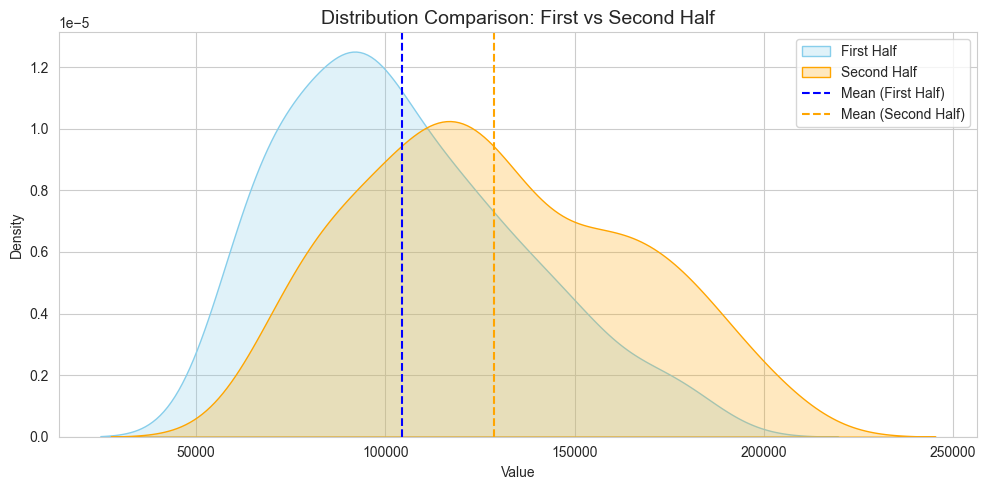

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# 🔸 Clean and flatten the data
originial_data2 = original_data.copy()
original_data2 = original_data2.values.ravel()
mid = len(original_data2) // 2

# Split the series
ts1 = original_data2[:mid]
ts2 = original_data2[mid:]

# Perform KS test
ks_stat, p_value = ks_2samp(ts1, ts2)

# Print result
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("❌ Reject H0: The distributions are different (not strictly stationary)")
else:
    print("✅ Fail to reject H0: No evidence distributions differ (possibly strictly stationary)")

# 🔹 Plot the distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(ts1, label='First Half', fill=True, color='skyblue')
sns.kdeplot(ts2, label='Second Half', fill=True, color='orange')

plt.title('Distribution Comparison: First vs Second Half', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Density')
plt.axvline(np.mean(ts1), color='blue', linestyle='--', label='Mean (First Half)')
plt.axvline(np.mean(ts2), color='orange', linestyle='--', label='Mean (Second Half)')
plt.legend()
plt.tight_layout()
plt.show()


Strict Stationarity (Strong Stationarity)
A time series is strictly stationary if its entire distribution does not change over time.

✔️ That means:
The mean, variance, skewness, kurtosis, etc. — all statistical properties are constant over time.

For any time points 
𝑡
1
,
𝑡
2
,
.
.
.
,
𝑡
𝑘
t 
1
​
 ,t 
2
​
 ,...,t 
k
​
 , the joint distribution of 
(
𝑋
𝑡
1
,
𝑋
𝑡
2
,
.
.
.
,
𝑋
𝑡
𝑘
)
(X 
t 
1
​
 
​
 ,X 
t 
2
​
 
​
 ,...,X 
t 
k
​
 
​
 ) is the same as 
(
𝑋
𝑡
1
+
ℎ
,
𝑋
𝑡
2
+
ℎ
,
.
.
.
,
𝑋
𝑡
𝑘
+
ℎ
)
(X 
t 
1
​
 +h
​
 ,X 
t 
2
​
 +h
​
 ,...,X 
t 
k
​
 +h
​
 ), for all 
ℎ
h.

✅ Very strict condition — rarely satisfied in real-world data.

2. Weak Stationarity (Second-order Stationarity)
A time series is weakly stationary if:

Mean is constant over time.

Variance is constant over time.

Covariance between two time points depends only on the lag (difference), not on actual time

This is the assumption used in most time series models (like ARIMA, SARIMA).

In [17]:
# Define the split date
test_start_date = '2022-12-01'

# Now slicing works correctly
training_data = original_data[:test_start_date]
test_data = original_data[test_start_date:]

training_series = training_data['SPCS20RPSNSA']
test_series = test_data['SPCS20RPSNSA']


In [96]:
training_data

array([ 76273,  70994,  72795,  79561,  92584, 102644, 111101, 115467,
       108515, 105465,  95800,  89610,  82219,  74830,  79845,  87896,
       104767, 116105, 128434, 134301, 124706, 114915,  98758,  94180,
        88055,  86304,  92158, 102771, 119604, 128773, 136760, 137574,
       129074, 121173, 108518, 107725,  98388,  93151,  91847,  99957,
       115874, 126973, 140118, 148022, 152053, 148106, 133614, 125061,
       109956, 103519, 107453, 120437, 139938, 156260, 172124, 181017,
       170892, 157723, 144715, 139743, 128895, 118615, 121230, 134260,
       152506, 167019, 174593, 185773, 178574, 170738, 151945, 140717,
       125286, 111890, 112609, 120659, 139293, 149866, 155827, 154134,
       139104, 131550, 119093, 113372, 103883,  95847,  97341, 100334,
       111420, 115492, 120100, 119970, 106051,  93938,  77518,  72062,
        63340,  58810,  59843,  67549,  78031,  87398,  95594,  98122,
        96276,  91098,  79649,  72964,  60884,  58571,  59041,  66930,
      

In [18]:
def plot_seasonal_decompose(data, model='multiplicative'):
    
    sns.set_style("whitegrid")

    decomposition = seasonal_decompose(data, model=model)

    fig, axes = plt.subplots(4, 1, figsize=(20, 14), sharex=True, gridspec_kw={'hspace': 0.5})

    # Original series
    axes[0].plot(data, color='royalblue', linewidth=1.5, alpha=0.9)
    axes[0].set_title('Original Time Series', fontsize=20)
    axes[0].grid(True)

    # Trend
    axes[1].plot(decomposition.trend, color='darkorange', linewidth=1.5)
    axes[1].set_title('Trend Component', fontsize=20)
    axes[1].grid(True)

    # Seasonality
    axes[2].plot(decomposition.seasonal, color='mediumseagreen', linewidth=1.5)
    axes[2].set_title('Seasonal Component', fontsize=20)
    axes[2].grid(True)

    # Residuals
    axes[3].plot(decomposition.resid, color='gray', linewidth=1.5)
    axes[3].set_title('Residual Component', fontsize=20)
    axes[3].grid(True)

    # Common tick and label sizes
    for ax in axes:
        ax.tick_params(axis='both', labelsize=14)

    plt.suptitle('Seasonal Decomposition of Time Series', fontsize=26, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

    return decomposition

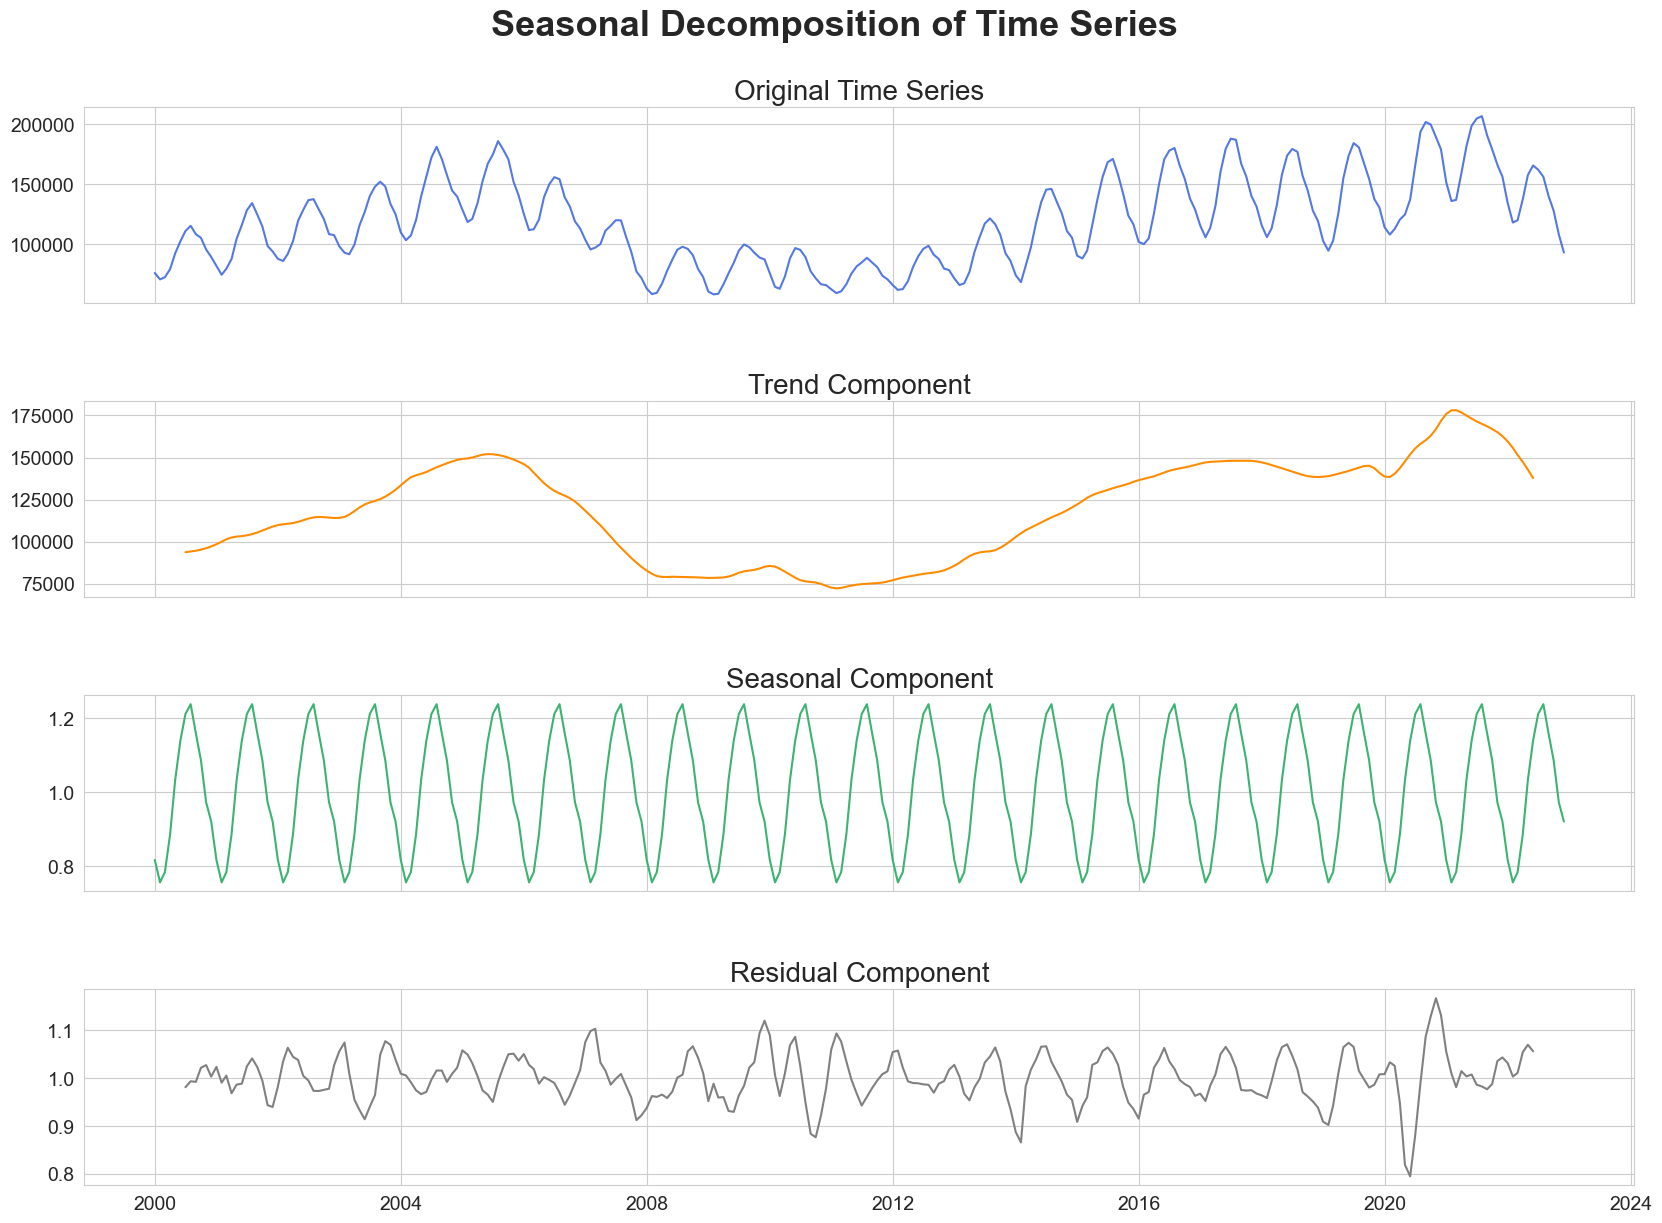

In [19]:
decomposition = plot_seasonal_decompose(training_series, model='multiplicative')

Breakdown of Components
✅ Original Time Series
Clear upward and downward trend over the years.

Seasonal oscillations (peaks and troughs) vary in height over time.

✅ Trend Component
Smooth long-term movement in the data (increasing and decreasing sections).

Supports the presence of a strong trend.

✅ Seasonal Component
The seasonal pattern stays regular in shape, but look at the scale:

Seasonal values fluctuate between ~0.8 and ~1.2, not centered around 0.

This indicates multiplicative seasonality, because:

In additive models, seasonal values typically center around 0.

In multiplicative models, they center around 1.

✅ Residual Component
Fluctuations around 1.0 rather than 0.

Again, this supports multiplicative decomposition.

If it were additive, residuals would be centered around 0.

✅ Final Conclusion
Your time series definitely follows a multiplicative structure.

## Checking for Cyclic behavious

In your decomposition:

After removing trend and seasonality, if the residuals show long-term wave-like patterns, those may be cyclic components.

However, if residuals look mostly random (which yours do), cyclic behavior is weak or not present.

In [20]:
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.signal import periodogram

def detect_cycles(series, freq='M'):
    """
    Detect cyclic behavior in a time series.

    Parameters:
        series (pd.Series): The time series data with a datetime index.
        freq (str): Frequency of the data (e.g., 'M' for monthly, 'Q' for quarterly)

    Returns:
        dict: Summary of cycle indicators.
    """
    # HP filter decomposition
    cycle, trend = hpfilter(series, lamb=1600 if freq == 'M' else 129600 if freq == 'Q' else 100)
    
    # Spectral density analysis
    freqs, power = periodogram(series.dropna(), scaling='spectrum')
    top_freqs = freqs[np.argsort(power)[-3:]]  # top 3 frequencies with highest power

    return {
        "Cycle Std Dev (HP Filter)": np.std(cycle),
        "Top Frequencies": top_freqs.tolist(),
        "Has Cyclic Component": np.std(cycle) > 0.05  # adjustable threshold
    }
result = detect_cycles(original_data['SPCS20RPSNSA'], freq='M')
print(result)

{'Cycle Std Dev (HP Filter)': np.float64(20559.25627136391), 'Top Frequencies': [0.08223684210526315, 0.003289473684210526, 0.006578947368421052], 'Has Cyclic Component': np.True_}


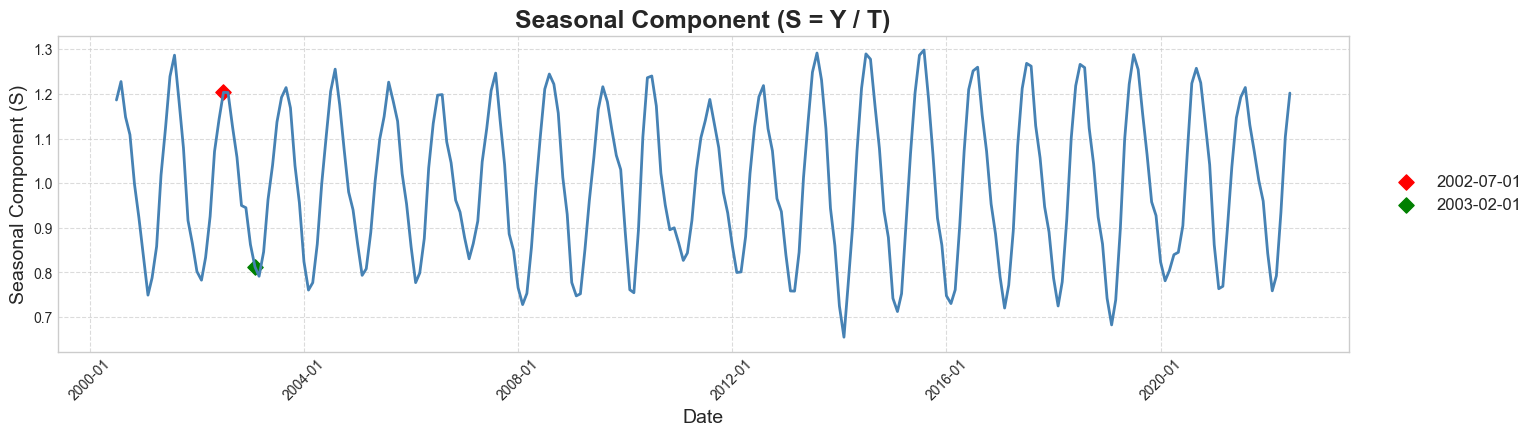

In [21]:
seasonal_component = training_series / decomposition.trend

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(seasonal_component, color='steelblue', linewidth=2)

ax.scatter(pd.to_datetime('2002-07-01'), seasonal_component.loc['2002-07-01'],
           marker='D', s=60, color='red', label='2002-07-01')
ax.scatter(pd.to_datetime('2003-02-01'), seasonal_component.loc['2003-02-01'],
           marker='D', s=60, color='green', label='2003-02-01')

ax.set_title('Seasonal Component (S = Y / T)', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seasonal Component (S)', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)

plt.tight_layout(pad=3)
plt.show()

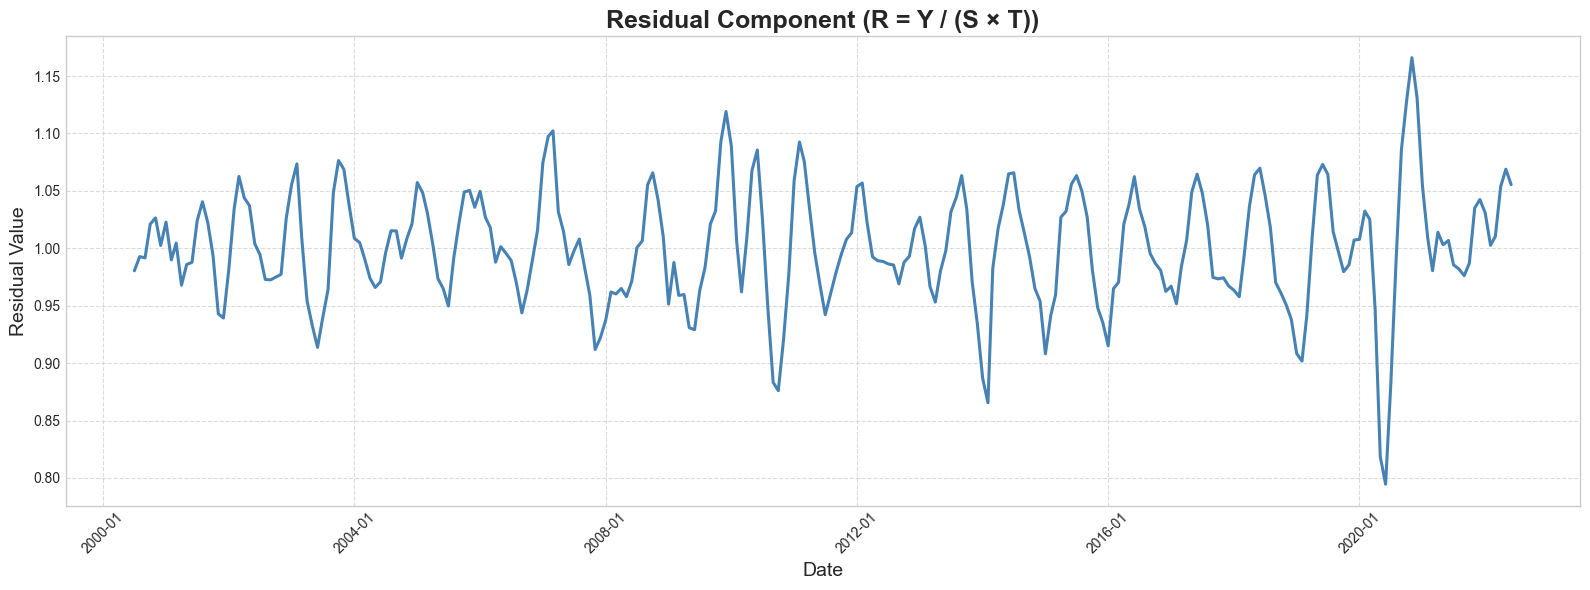

In [22]:
residual_component = training_series / (decomposition.trend * decomposition.seasonal)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(residual_component, color='steelblue', linewidth=2.2)

ax.set_title('Residual Component (R = Y / (S × T))', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Residual Value', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

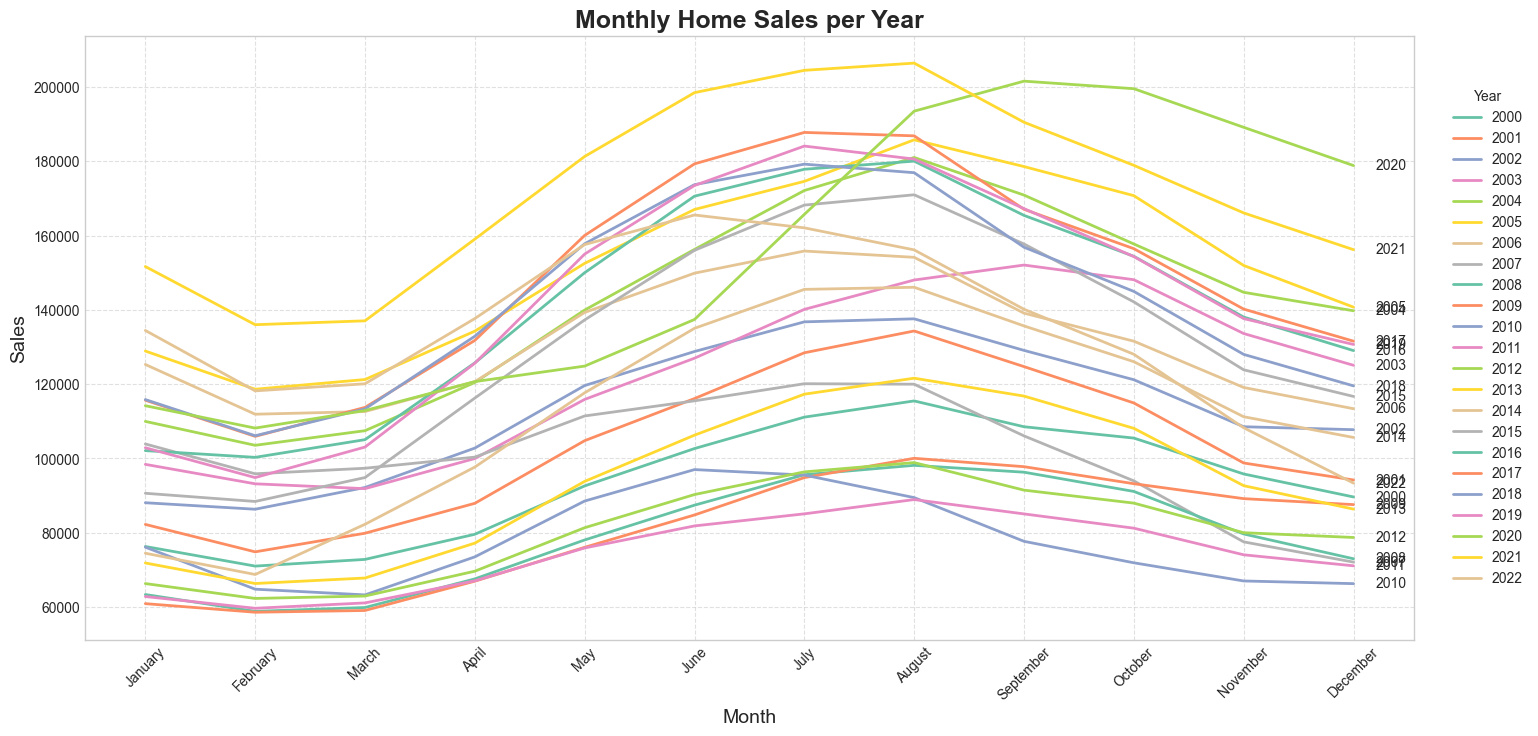

In [23]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(True, which='both', linestyle='--', alpha=0.6)

years = int(np.round(len(training_data) / 12))
months = training_data.index[:12].month_name()

for i in range(years):
    index = training_data.index[i * 12:(i + 1) * 12]
    monthly_values = training_data.loc[index].values
    
    ax.plot(months, monthly_values, linewidth=2)
    ax.text(x=11.2, y=monthly_values[-1], s=str(training_data.index.year.unique()[i]),
            fontsize=10, verticalalignment='center')

ax.set_title('Monthly Home Sales per Year', fontsize=18, fontweight='bold')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.xticks(rotation=45)
ax.legend(training_data.index.year.unique(), title='Year', bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=10)

plt.tight_layout(pad=3)
plt.show()

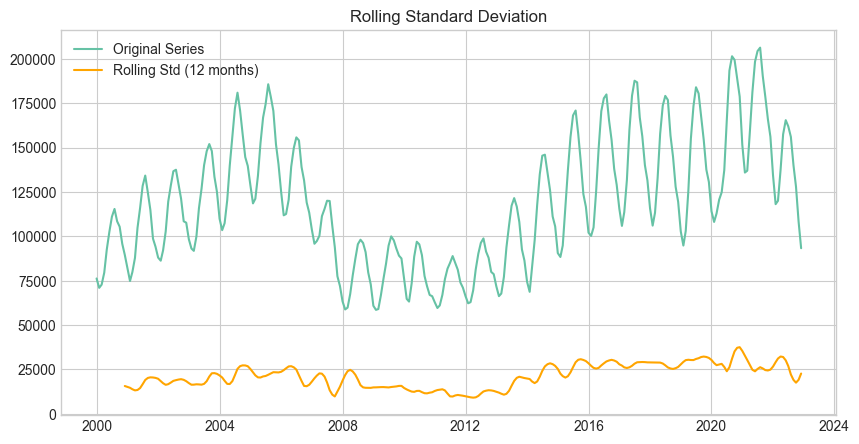

In [24]:
rolling_std = training_data.rolling(window=12).std()

plt.figure(figsize=(10, 5))
plt.plot(training_series, label='Original Series')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='orange')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show()


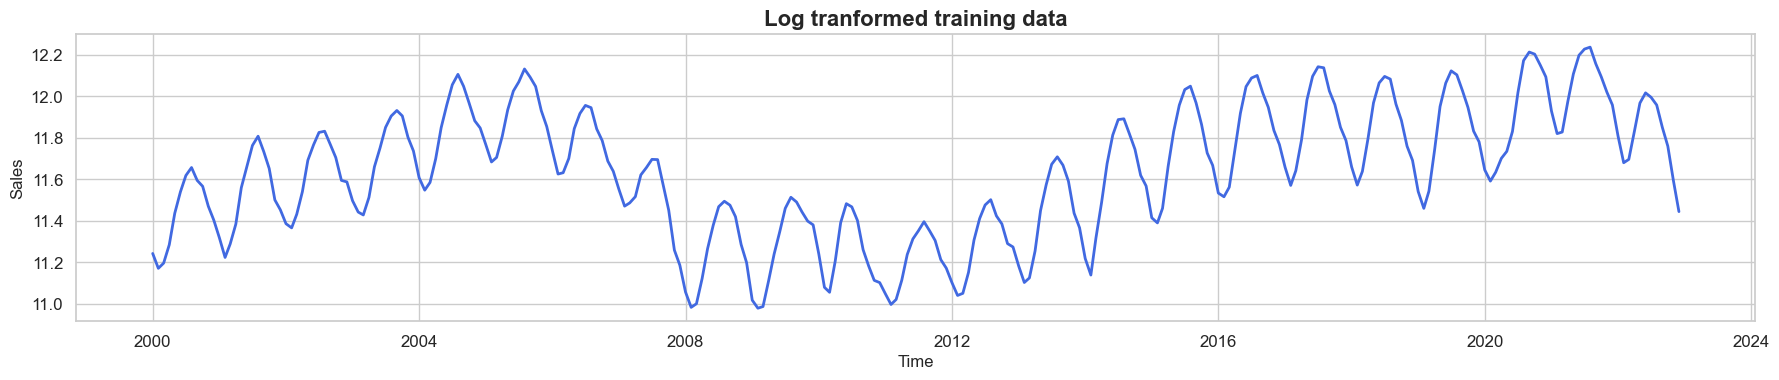

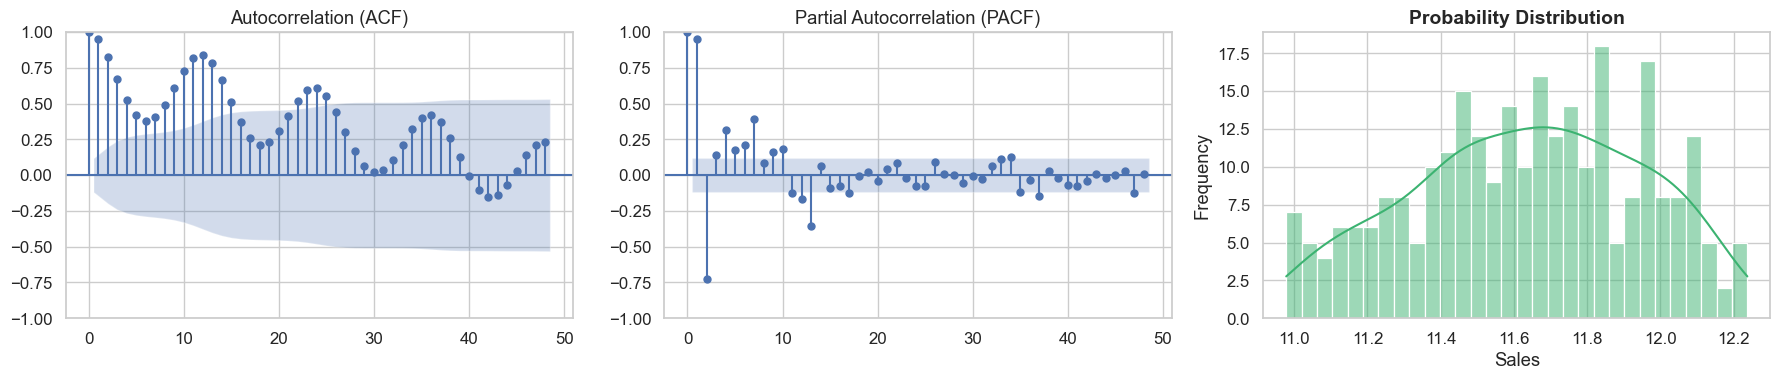

In [101]:
log_transformed_data = np.log(training_series)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [26]:
test_stationarity(log_transformed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.5548
p-value       : 0.1027
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.7105
p-value        : 0.0126
→ Reject H₀: Series is NOT stationary


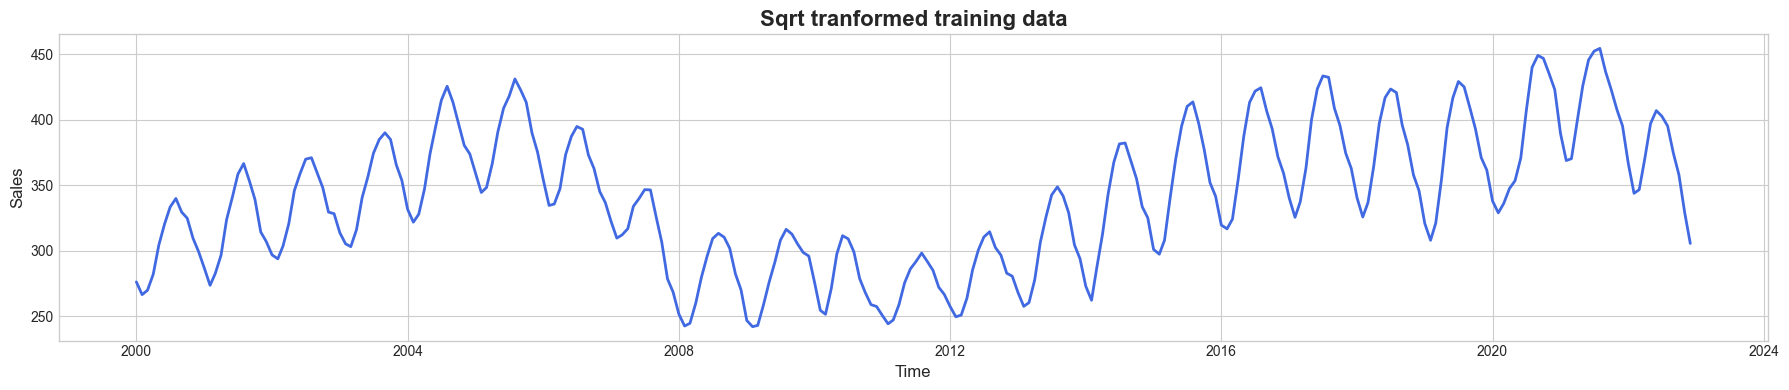

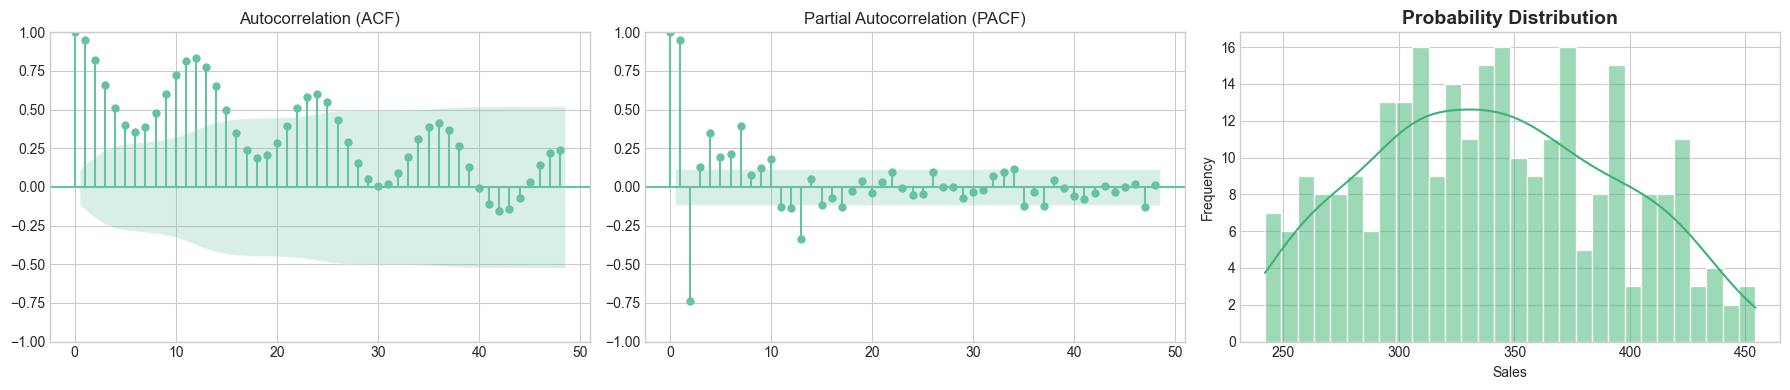

In [27]:
# lets try sqrt transformation 
# Square root transformation
train_sqrt = np.sqrt(training_series)
plot_data_properties(train_sqrt, 'Sqrt tranformed training data')

In [28]:
test_stationarity(log_transformed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.5548
p-value       : 0.1027
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.7105
p-value        : 0.0126
→ Reject H₀: Series is NOT stationary


Box-Cox Lambda: 0.2619


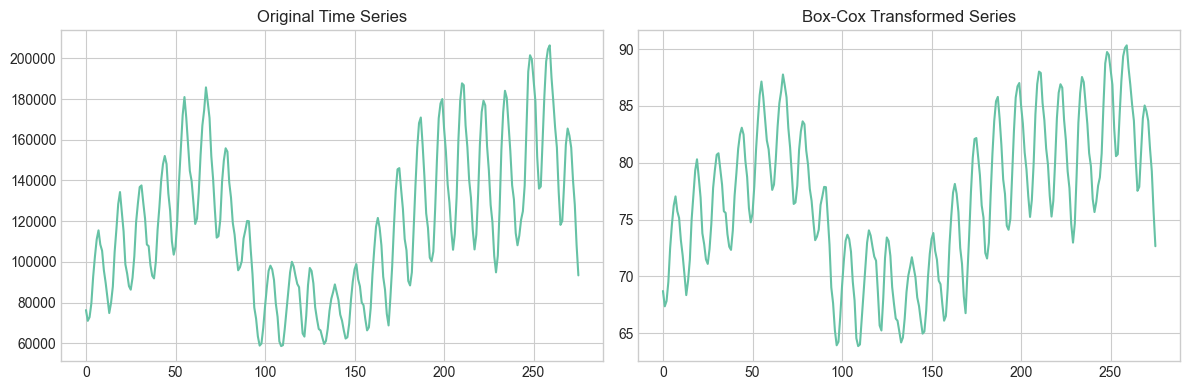


ADF Statistic: -2.6375
p-value: 0.0855
❌ Still non-stationary (fail to reject H0). Consider differencing next.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# Ensure positive and convert to array
training_data = training_data[training_data > 0].values.ravel()

# Apply Box-Cox
ts_boxcox, fitted_lambda = boxcox(training_data)

print(f"Box-Cox Lambda: {fitted_lambda:.4f}")

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_data)
plt.title("Original Time Series")

plt.subplot(1, 2, 2)
plt.plot(ts_boxcox)
plt.title("Box-Cox Transformed Series")

plt.tight_layout()
plt.show()

# ADF Test
result = adfuller(ts_boxcox)
print(f"\nADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

if result[1] < 0.05:
    print("✅ Transformed series is stationary (reject H0).")
else:
    print("❌ Still non-stationary (fail to reject H0). Consider differencing next.")


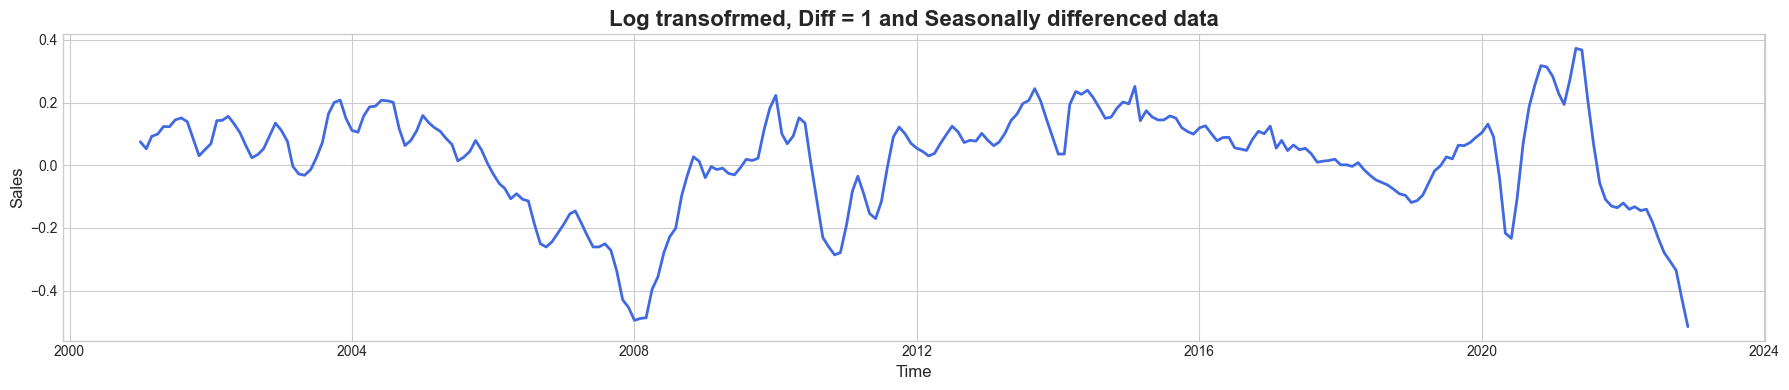

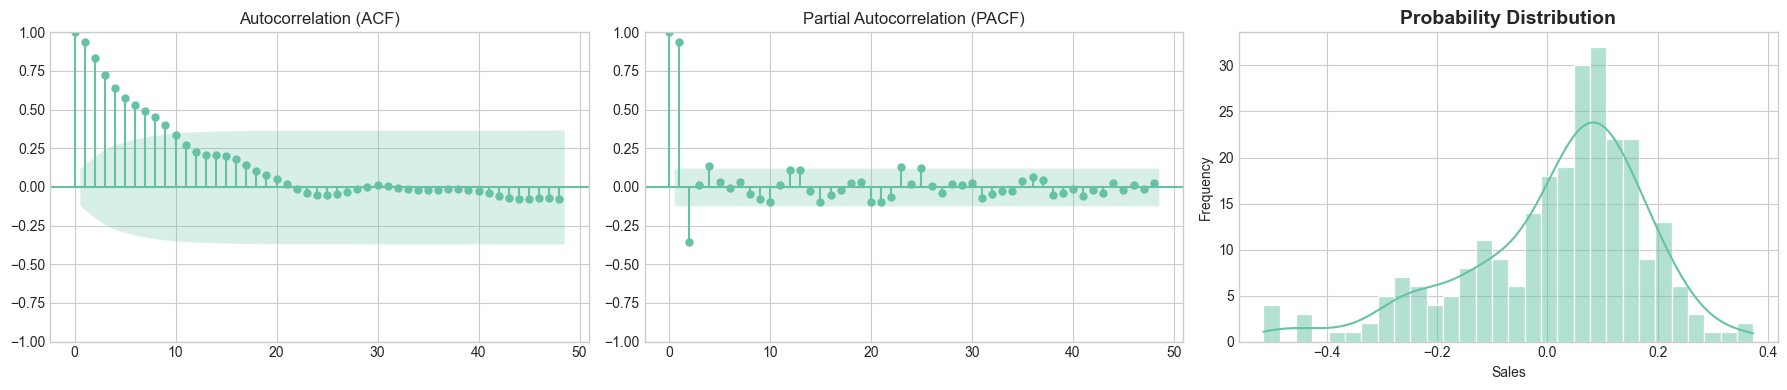

In [31]:
seasonally_diffed_data = log_transformed_data.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, Diff = 1 and Seasonally differenced data')

In [32]:
test_stationarity(seasonally_diffed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.3641
p-value       : 0.1521
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.1494
p-value        : 0.1000
→ Fail to reject H₀: Series is STATIONARY


### From the acf plot we see a slow hyperbolic decay and the adf and kpss also gives a mixed ans so there is a sign of long term memory , then lets test with hurst exponent and some visual checks


In [41]:
seasonally_diffed_data

,SPCS20RPSNSA
observation_date,
2001-01-01,0.075067
2001-02-01,0.052624
2001-03-01,0.092440
2001-04-01,0.099630
2001-05-01,0.123622
...,...
2022-08-01,-0.279229
2022-09-01,-0.306965
2022-10-01,-0.334622


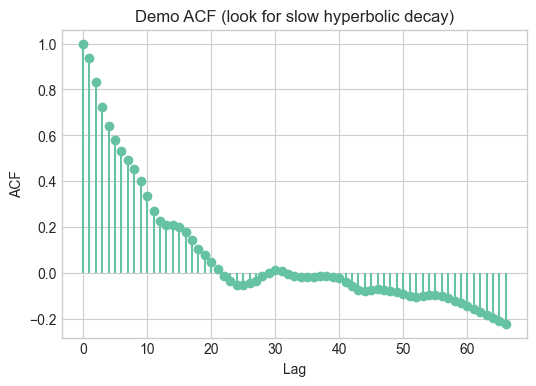

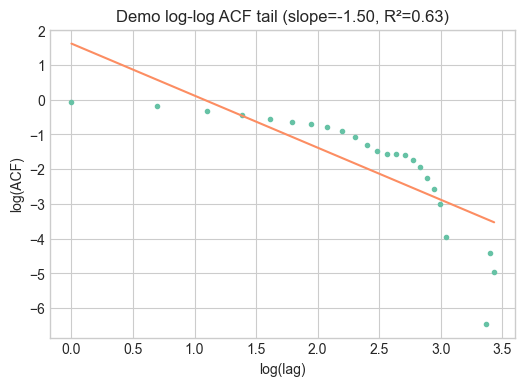

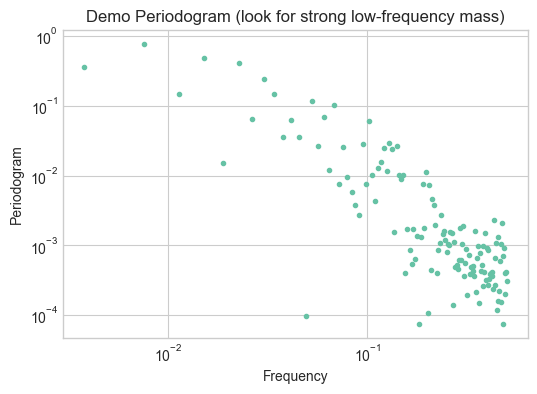

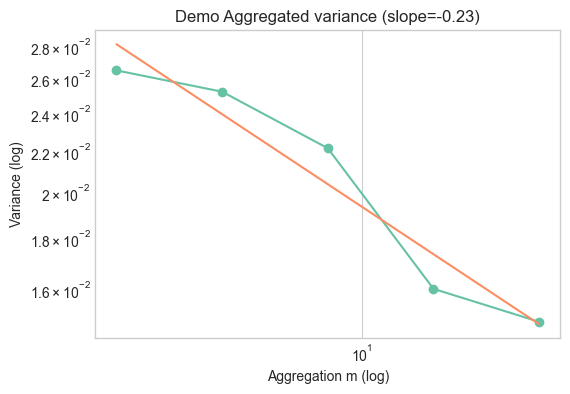

GPH d̂ = 0.349 (SE ~ 0.037)
Hurst (R/S) H ≈ 0.932
DFA α ≈ 1.193
ADF: stat=-2.364, p=0.152  (H0: unit root)
KPSS: stat=0.149, p=0.100  (H0: stationary)
Ljung-Box(20): Q=1125.96, p=0.000
Recommendation: Stationary long-memory (0 < d < 0.5): ARFIMA(p,d,q) is appropriate; include short-run ARMA terms as needed.
Notes: Strong long-memory signal (d > 0.2).
{'d': np.float64(0.3488179116627024), 'd_se': np.float64(0.03674161022955604), 'H': np.float64(0.932489953752711), 'alpha': np.float64(1.1933273305446024), 'recommendation': 'Stationary long-memory (0 < d < 0.5): ARFIMA(p,d,q) is appropriate; include short-run ARMA terms as needed.', 'notes': ['Strong long-memory signal (d > 0.2).']}


In [45]:
z = seasonally_diffed_data.squeeze()     # convert (n,1) DataFrame → 1D Series
z = z.dropna()                           # remove NaNs created by differencing
z.index = pd.to_datetime(z.index)        # ensure datetime index
z = z.asfreq('MS')                       # enforce monthly freq



_ = visual_checks(z, title_prefix="Demo")
out = recommend_model(z)
print(out)

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------- helpers --------------------
def coerce_to_monthly_series(obj, date_level_name="observation_date", value_col=None, freq="MS"):
    """
    Make a 1-D Series with a monthly DatetimeIndex from many shapes:
    - Series with DateTimeIndex
    - DataFrame with (Multi)Index containing a date level
    - DataFrame with DatetimeIndex
    - DataFrame with a date column named `date_level_name`
    """
    if isinstance(obj, pd.Series):
        s = obj.copy()
        if not isinstance(s.index, pd.DatetimeIndex):
            s.index = pd.to_datetime(s.index)
        s = s.sort_index().asfreq(freq)
        return s

    # DataFrame path
    df = obj.copy()

    # If MultiIndex, try to use the specified date level
    if isinstance(df.index, pd.MultiIndex):
        if date_level_name in df.index.names:
            df = df.reset_index(level=[n for n in df.index.names if n != date_level_name])
            df = df.reset_index().set_index(date_level_name)
        else:
            # fallback: fully reset and try to auto-detect a datetime column
            df = df.reset_index()

    # If there's a date column, use it as index
    if date_level_name in df.columns:
        df = df.set_index(date_level_name)

    # choose the first/asked value column
    if value_col is None:
        value_col = df.columns[0]
    s = df[value_col].astype(float).squeeze()

    # ensure DatetimeIndex + monthly freq
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)
    s = s.sort_index().asfreq(freq)
    return s

def fracdiff_series(x: pd.Series, d: float, tol: float = 1e-5) -> pd.Series:
    """
    Fractional differencing (binomial weights). Returns a Series aligned to x, with initial NaNs dropped.
    """
    w = [1.0]
    while True:
        w_k = w[-1] * (len(w) - 1 - d) / len(w)
        if abs(w_k) < tol:
            break
        w.append(w_k)
    w = np.array(w, float)

    vals = x.values.astype(float)
    out = np.full_like(vals, np.nan, dtype=float)
    for t in range(len(vals)):
        kmax = min(t + 1, len(w))
        out[t] = np.dot(w[:kmax][::-1], vals[t - kmax + 1: t + 1])
    return pd.Series(out, index=x.index).dropna()

# -------------------- main --------------------
def fit_arfima_sarima_fd(
    z,                      # your log seasonal differenced data (any of Series/DataFrame/MultiIndex)
    d_frac: float,
    p_grid=range(0,3),
    q_grid=range(0,3),
    P_grid=range(0,2),
    Q_grid=range(0,2),
    s: int = 12,
    steps: int = 12,
    plot: bool = True,
    date_level_name="observation_date",
    value_col=None
):
    """
    Fits SARIMAX on fractional-differenced z (which is already log seasonal differenced).
    Seasonal differencing D=0 (you already did seasonal diff outside).
    Returns forecasts in the SAME transformed space (no inverse transform).
    """
    # 1) coerce to 1-D monthly Series
    z_series = coerce_to_monthly_series(z, date_level_name=date_level_name, value_col=value_col, freq="MS")

    # 2) fractional difference
    z_fd = fracdiff_series(z_series, d=d_frac)  # this is the modeling series

    # 3) grid-search SARIMA on z_fd with D=0
    best = {"aic": np.inf, "res": None}
    for p in p_grid:
        for q in q_grid:
            for P in P_grid:
                for Q in Q_grid:
                    try:
                        mod = SARIMAX(
                            endog=z_fd,
                            order=(p, 0, q),                  # d=0 because we've fractional-differenced already
                            seasonal_order=(P, 0, Q, s),      # D=0 because seasonal diff already done
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )
                        res = mod.fit(method="lbfgs", disp=False)
                        if res.aic < best["aic"]:
                            best = {
                                "aic": res.aic,
                                "order": (p, 0, q),
                                "seasonal": (P, 0, Q, s),
                                "res": res
                            }
                    except Exception as e:
                        # optional: print(f"skip {(p,0,q)}x{(P,0,Q,s)} -> {e}")
                        pass

    res = best["res"]
    if res is None:
        raise RuntimeError("No SARIMA fit succeeded. Check your data after coercion and fracdiff.")

    # 4) forecast in fd-space (same space as z_fd)
    fc = res.get_forecast(steps=steps).predicted_mean
    fc.index.freq = z_series.index.freq  # keep monthly index

    # 5) plot (actual transformed series vs forecast in same space)
    if plot:
        plt.figure(figsize=(9,4))
        plt.plot(z_series.index, z_series, label="z = log(level) - log(level-12)")
        plt.plot(z_fd.index, z_fd, label="fracdiff(z)", alpha=0.7)
        plt.plot(fc.index, fc.values, label="Forecast on fracdiff(z)")
        plt.title("ARFIMA (SARIMA on fracdiff of log seasonal differenced data)")
        plt.xlabel("Time"); plt.ylabel("Transformed Units")
        plt.legend(); plt.tight_layout(); plt.show()

    return {
        "order": best["order"],
        "seasonal_order": best["seasonal"],
        "aic": best["aic"],
        "fd_train": z_fd,                  # training series in fd-space
        "fd_forecast": fc                  # forecast in the SAME space
    }


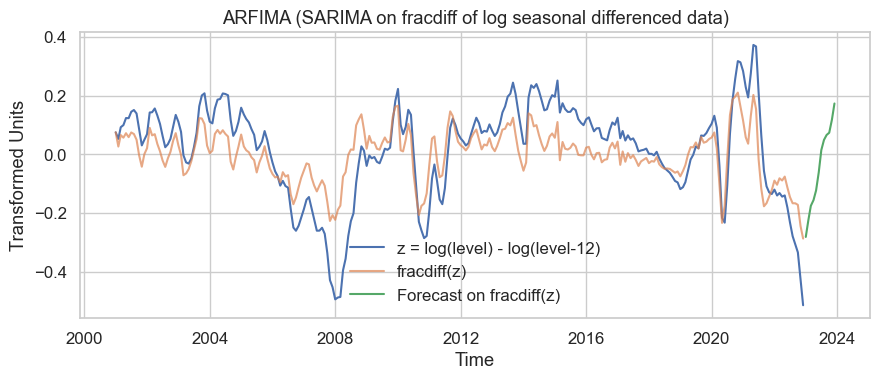

Best: (1, 0, 2) (0, 0, 1, 12) AIC: -1003.5552117239686
2023-01-01   -0.281885
2023-02-01   -0.223158
2023-03-01   -0.175690
2023-04-01   -0.156351
2023-05-01   -0.123221
Freq: MS, Name: predicted_mean, dtype: float64


In [95]:
# Your estimates
dhat = 0.349

out = fit_arfima_sarima_fd(
    z=seasonally_diffed_data,     # your DataFrame/MultiIndex from the screenshot
    d_frac=dhat,
    p_grid=range(0,3),
    q_grid=range(0,3),
    P_grid=range(0,2),
    Q_grid=range(0,2),
    s=12,
    steps=12,
    plot=True,
    date_level_name="observation_date",   # matches your index level in the screenshot
    value_col="SPCS20RPSNSA"              # your value column
)

print("Best:", out["order"], out["seasonal_order"], "AIC:", out["aic"])
print(out["fd_forecast"].head())


#### In the above plot , we first seasonally differenced the data after log transforming and then we saw long memory on the data so we fitted an Arfima model using sarima with P,Q terms and D=0 ( since we already did seasonal diff) where fractional differencing is done manually before fitting the sarima (d=0,D=0) and then we got a forecast on the same scale

#### Doing forecast on the actual scale was very difficult and was causing lot of issue so did the forecast on the log seasonal diffed data only

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(seasonally_diffed_data, lags=[10, 20, 30], return_df=True)

print(lb_test)

       lb_stat     lb_pvalue
10  129.408971  6.165714e-23
20  228.206445  2.734347e-37
30  253.079459  3.852233e-37


If you're testing your seasonal_diffed_data using Ljung-Box, then:

H₀ (null): Data is white noise (no autocorrelation → no pattern).

H₁ (alt): Data is autocorrelated (some structure → potentially modelable).

📌 So:
p-value > 0.05	Your differenced data is white noise → ❌ Not useful for ARIMA modeling
p-value ≤ 0.05	Your differenced data has autocorrelation → ✅ Can be modeled

In [48]:
def shapiro_normality_test(data):
    
    stat, p_value = shapiro(data)
    mean = np.round(np.mean(data), 3)
    std = np.round(np.std(data), 3)
    
    print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
    print(f"P-Value: {p_value:.3f}")
    
    if p_value >= 0.05:
        print(f"\033[92mData appears to be normally distributed (X ~ N({mean}, {std})).\033[0m")
    else:
        print(f"\033[91mData does NOT follow a normal distribution (p < 0.05).\033[0m")

shapiro_normality_test(seasonally_diffed_data.SPCS20RPSNSA)

Shapiro-Wilk Test Statistic: 0.964
P-Value: 0.000
Data does NOT follow a normal distribution (p < 0.05).


It is actually irrelevant to check for normality of the data incase of time series but i still did it so ignore

Behavior	ACF Pattern	PACF Pattern	Likely Conclusion 

Long decay in ACF	Slowly decaying	One strong spike, then fade	Non-stationary, trending

Short decay in ACF	Cuts off after few lags	Sharp cutoff	Stationary

Seasonal structure	Regular spikes at seasonal lag	Regular spikes at seasonal lag	Seasonal, may still be stationary after seasonal differencing

In [70]:
def best_sarima_model(train_data, p, q, P, Q, d=1, D=1, s=12):
    
    best_model_aic = np.inf
    best_model_bic = np.inf
    best_model_hqic = np.inf
    best_model_order = None
    best_model = None
    models = []

    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        model = SARIMAX(endog=train_data,
                                        order=(p_, d, q_),
                                        seasonal_order=(P_, D, Q_, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit(disp=False)
                        
                        models.append(model)

                        no_of_better_metrics = sum([
                            model.aic <= best_model_aic,
                            model.bic <= best_model_bic,
                            model.hqic <= best_model_hqic
                        ])

                        if no_of_better_metrics >= 2:
                            best_model = model
                            best_model_aic = np.round(model.aic, 2)
                            best_model_bic = np.round(model.bic, 2)
                            best_model_hqic = np.round(model.hqic, 2)
                            best_model_order = (p_, d, q_, P_, D, Q_, s)

                            print(f"Best so far: SARIMA{best_model_order} | "
                                  f"AIC={best_model_aic}, BIC={best_model_bic}, HQIC={best_model_hqic}, "
                                  f"Residual Mean={np.round(np.mean(np.abs(model.resid)), 4)}")

                    except Exception as e:
                        print(f"Failed for SARIMA({p_},{d},{q_})x({P_},{D},{Q_},{s}) → {e}")

    print("\nFinal Best SARIMA Model:")
    print(best_model.summary())

    return best_model, models

In [71]:
best_model, models = best_sarima_model(train_data=log_transformed_data, p=range(3), q=range(3), P=range(3), Q=range(3))

Best so far: SARIMA(0, 1, 0, 0, 1, 0, 12) | AIC=-838.87, BIC=-835.3, HQIC=-837.43, Residual Mean=0.1045
Best so far: SARIMA(0, 1, 0, 0, 1, 1, 12) | AIC=-898.45, BIC=-891.4, HQIC=-895.61, Residual Mean=0.0988
Best so far: SARIMA(0, 1, 1, 0, 1, 0, 12) | AIC=-910.81, BIC=-903.69, HQIC=-907.95, Residual Mean=0.1007
Best so far: SARIMA(0, 1, 1, 0, 1, 1, 12) | AIC=-962.8, BIC=-952.24, HQIC=-958.55, Residual Mean=0.0957
Best so far: SARIMA(0, 1, 2, 0, 1, 1, 12) | AIC=-1010.11, BIC=-996.06, HQIC=-1004.45, Residual Mean=0.0928

Final Best SARIMA Model:
                                      SARIMAX Results                                       
Dep. Variable:                         SPCS20RPSNSA   No. Observations:                  276
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 509.055
Date:                              Sun, 09 Nov 2025   AIC                          -1010.110
Time:                                      15:36:50   BIC                     

ARIMA (AutoRegressive Integrated Moving Average)
✅ ARIMA Assumptions:
Assumption	Description
1. Stationarity	The time series should be stationary (constant mean, variance, autocorrelation). Differencing (the "I" in ARIMA) is used to achieve this.
2. Linearity	The relationship between current values and past values/errors is linear.
3. No autocorrelation in residuals	After fitting, residuals should be white noise — no structure left.
4. Errors are uncorrelated and have constant variance (homoscedasticity)	Residuals should have constant spread (no clustering or volatility patterns).
5. Residuals are normally distributed (optional but helpful)	Not required for forecasting, but helps with confidence intervals and hypothesis testing.

📘 SARIMA (Seasonal ARIMA)
SARIMA extends ARIMA by adding seasonal terms — useful when your data has strong seasonal patterns (e.g., yearly, monthly, quarterly).

✅ SARIMA Assumptions = ARIMA Assumptions + Seasonal Stationarity
Additional Assumption	Description

6. Seasonal Stationarity	Seasonal patterns (e.g., yearly) must be stable across time. You can achieve this with seasonal differencing.

7. Correct seasonal period	You must specify the correct seasonal period (e.g., 12 for monthly data with yearly seasonality).

8. No seasonal autocorrelation in residuals	Just like non-seasonal ARIMA, SARIMA expects white noise residuals, including no seasonal lag spikes in ACF/PACF of residuals.

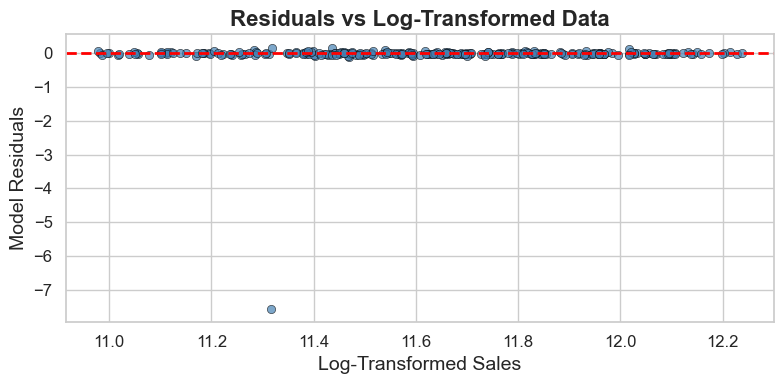

In [72]:
x_vals = log_transformed_data[1:].values.ravel()
y_vals = best_model.resid[1:].values.ravel()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.scatterplot(x=x_vals, y=y_vals, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Log-Transformed Data', fontsize=16, fontweight='bold')
plt.xlabel('Log-Transformed Sales', fontsize=14)
plt.ylabel('Model Residuals', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We are checking for linearity between current value and past values
✅ Interpretation: 
What You See	What It Means
Random cloud around 0	✅ Linearity assumption holds
Curved, funnel, or pattern	❌ Possible non-linearity or heteroscedasticity

So the linearity holds

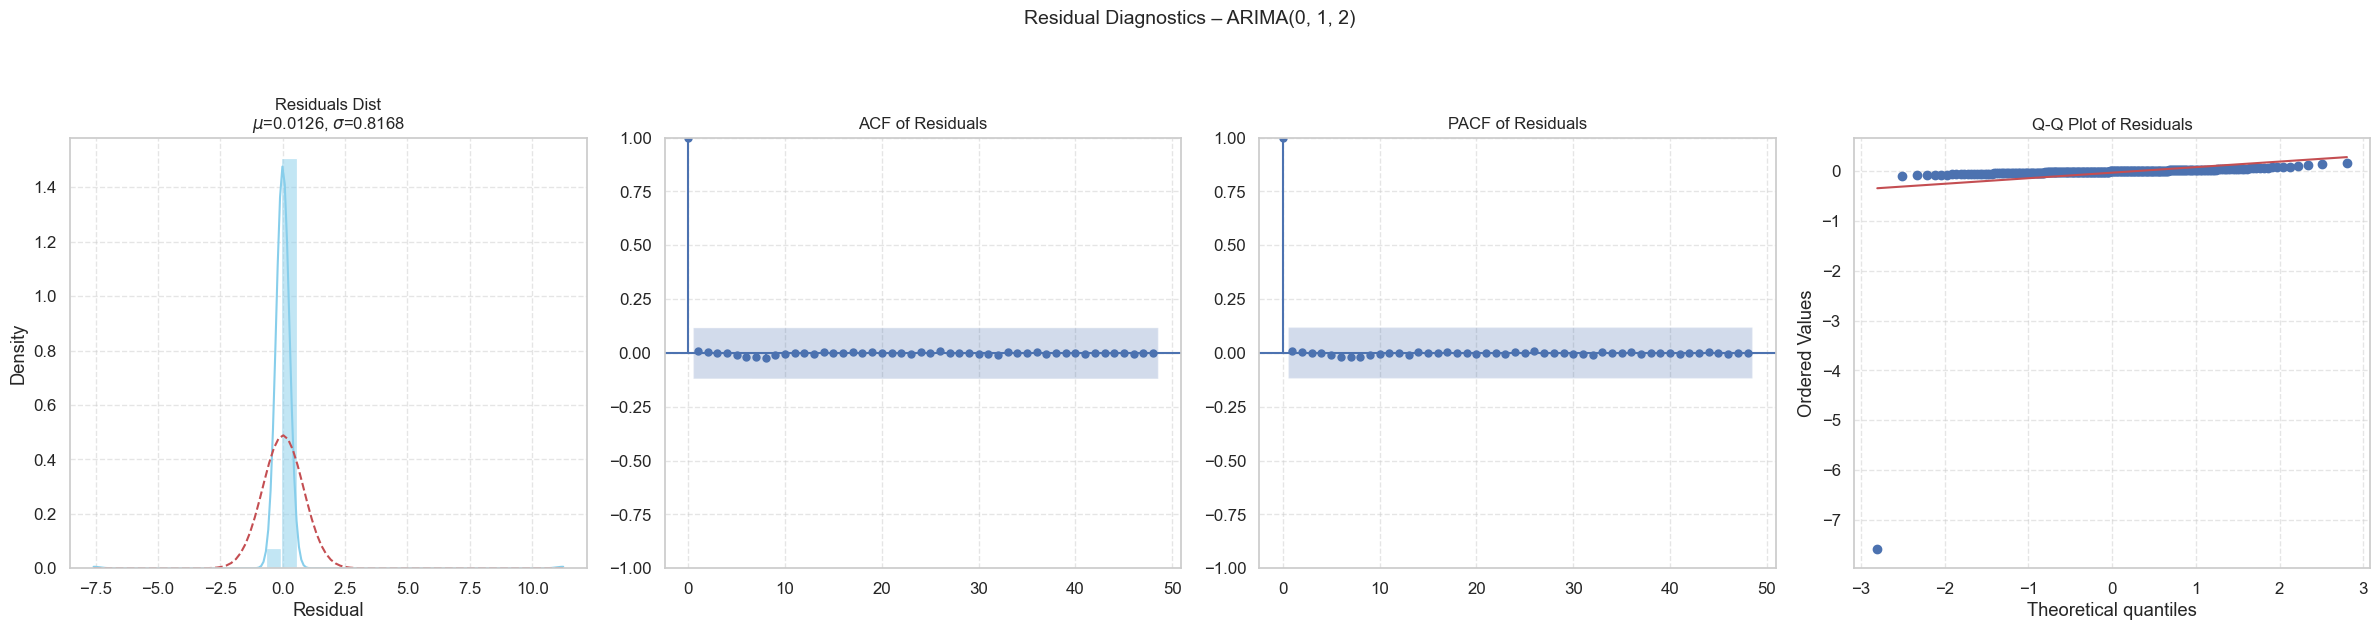

In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(style='whitegrid', font_scale=1.1)

resid = best_model.resid
mu, sigma = stats.norm.fit(resid)

fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # 1 row, 4 columns

# --- Histogram + KDE + Fitted Normal Curve ---
sns.histplot(resid, kde=True, stat="density", bins=30, color='skyblue', ax=axes[0])
x = np.linspace(resid.min(), resid.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r--')
axes[0].set_title(f'Residuals Dist\n$\mu$={mu:.4f}, $\sigma$={sigma:.4f}', fontsize=12)
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- ACF Plot ---
plot_acf(best_model.resid[1:].squeeze(), lags=48, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of Residuals', fontsize=12)
axes[1].set_ylim(-1, 1)
axes[1].grid(True, linestyle='--', alpha=0.5)

# --- PACF Plot ---
plot_pacf(best_model.resid[1:].squeeze(), lags=48, ax=axes[2], alpha=0.05, method='ywm')
axes[2].set_title('PACF of Residuals', fontsize=12)
axes[2].set_ylim(-1, 1)
axes[2].grid(True, linestyle='--', alpha=0.5)

# --- Q-Q Plot ---
stats.probplot(best_model.resid[1:].squeeze(), dist="norm", plot=axes[3])
axes[3].set_title('Q-Q Plot of Residuals', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.5)

# --- Main Title and Layout ---
plt.suptitle(f'Residual Diagnostics – ARIMA{best_model.model.order}', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Residuals is not compulsory to be normal , its needed to be normal at that time when we are doing tests for any hypothesis or finding confidence intervals

In [74]:
lb_test = acorr_ljungbox(resid, lags=range(10, 70), return_df=True)
print(lb_test)

      lb_stat     lb_pvalue
10   0.097187  1.000000e+00
11   0.099305  1.000000e+00
12  62.146881  9.141208e-09
13  62.150354  2.160404e-08
14  62.153848  4.899471e-08
15  62.153848  1.071144e-07
16  62.154627  2.259770e-07
17  62.154643  4.614231e-07
18  62.155399  9.132887e-07
19  62.155560  1.756361e-06
20  62.156906  3.285078e-06
21  62.157855  5.988223e-06
22  62.158920  1.065042e-05
23  62.159438  1.850858e-05
24  62.160159  3.145435e-05
25  62.162032  5.231109e-05
26  62.162351  8.528943e-05
27  62.162385  1.363859e-04
28  62.162478  2.140479e-04
29  62.163055  3.299011e-04
30  62.163642  4.997443e-04
31  62.164524  7.444671e-04
32  62.165444  1.091364e-03
33  62.165448  1.575700e-03
34  62.165652  2.241066e-03
35  62.169456  3.138801e-03
36  62.170420  4.338286e-03
37  62.170454  5.916864e-03
38  62.174413  7.957588e-03
39  62.174564  1.057651e-02
40  62.174867  1.388489e-02
41  62.175857  1.800931e-02
42  62.176360  2.309251e-02
43  62.176603  2.928140e-02
44  62.184917  3.667

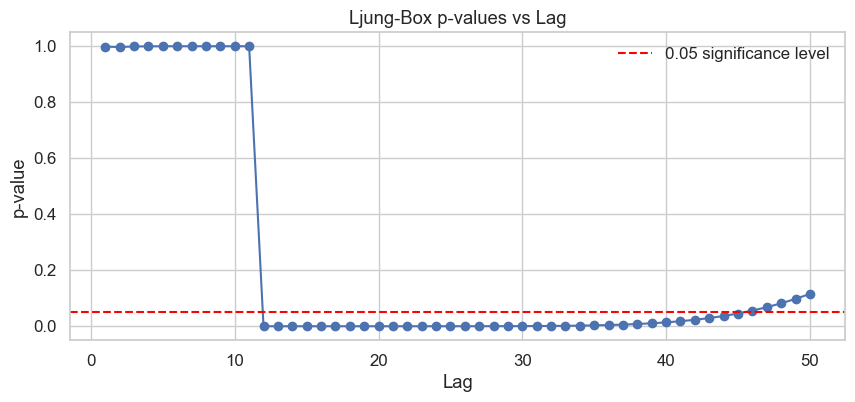

In [75]:
import matplotlib.pyplot as plt

# Run Ljung-Box test up to 50 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(best_model.resid, lags=50, return_df=True)

# Plot p-values
plt.figure(figsize=(10, 4))
plt.plot(lb_result.index, lb_result['lb_pvalue'], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung-Box p-values vs Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()


So we see as the number of lags increased , our residuals shows white noise which proved the assumption of arima and sarima models

In [76]:
from statsmodels.stats.diagnostic import het_arch

# Assuming you have residuals from SARIMA model
arch_test = het_arch(best_model.resid)

print("LM Statistic:", arch_test[0])
print("p-value:", arch_test[1])


LM Statistic: 0.040001389224495476
p-value: 0.9999999999737694


Why It Matters
If your residuals are heteroscedastic, traditional models like ARIMA or SARIMA may produce inefficient forecasts.

You may need models like GARCH to handle the volatility properly.

📊 What Is the ARCH Test?
The ARCH test checks whether:

The variance of the residuals at time t depends on past squared residuals.

In short: If today's variance is influenced by yesterday's errors, you're seeing conditional heteroscedasticity.

🔬 How It Works (Conceptually)
Fit your time series model (like SARIMA) and get the residuals.

Square the residuals.

Regress the squared residuals on lagged squared residuals.

Test if the coefficients are statistically significant.

✅ Interpretation
Null Hypothesis (H₀): No ARCH effect (i.e., residuals are homoscedastic).

Alternative Hypothesis (H₁): ARCH effects present (i.e., heteroscedastic residuals).

If the p-value < 0.05, reject H₀ ⇒ residuals are heteroscedastic.

So we see our p values is highly larger than 0.05 so we conclude our residuals is homoscedastic in nature and the asumption holds



Text(0.5, 1.0, 'ACF of Squared Residuals')

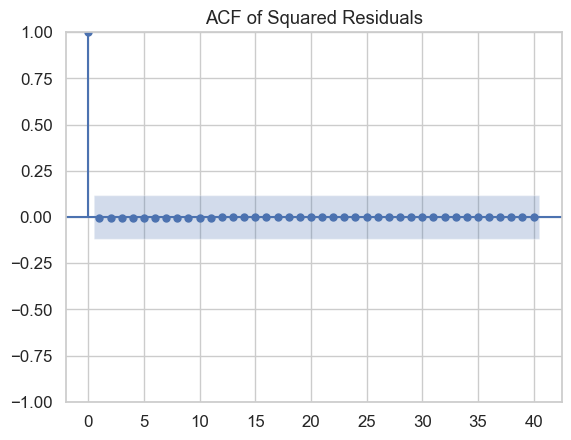

In [127]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(best_model.resid[1:].squeeze()**2, lags=40)
plt.title("ACF of Squared Residuals")

### Using the acf of squared residuals we can also check if the residuals have changing varicance or not basically checking arch effect , if there are significant spikes at intial lags then it is a sign of changing variance or volatiity

Text(0.5, 1.0, 'Rolling Standard Deviation')

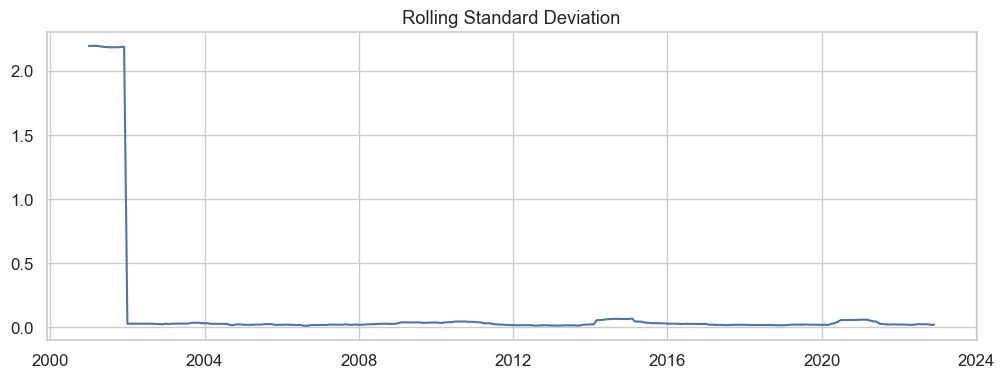

In [128]:
plt.figure(figsize=(12,4))
plt.plot(best_model.resid[1:].squeeze().rolling(12).std())
plt.title("Rolling Standard Deviation")

### Another visual check to see if there is changing variance is to plot the rolling std of residuals , if there is ups and downs then its changing variance
### ✅ There is no volatility clustering in your residuals.

Except one weird, huge spike at the beginning (probably an initialization artifact or a bad first rolling window).
After that, the rolling standard deviation is basically flat, like a calm lake.

What this means in plain words

The variance of your residuals is pretty much constant over time.

No clumping of high volatility periods.

GARCH-style models would not add anything here.

Your SARIMA residuals behave like homoskedastic noise.

<Figure size 1200x600 with 0 Axes>

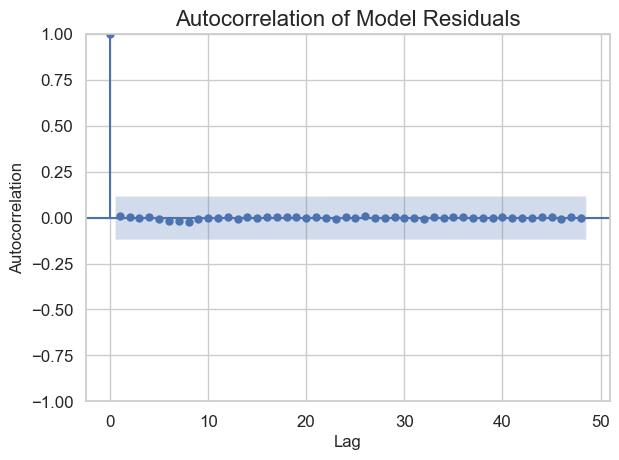

In [78]:
plt.figure(figsize=(12, 6))

plot_acf(best_model.resid[1:].squeeze(), lags=48, alpha=0.05)

plt.title('Autocorrelation of Model Residuals', fontsize=16)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## All autocorrelations (for lags 1 to 20) are:

Very close to zero

Inside the blue confidence bands (typically 95% CI)

🔍 Interpretation:
✅ No significant autocorrelation in residuals → residuals are random

✅ Residuals resemble white noise, which is what we want after fitting an ARIMA/SARIMA model

In [86]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)  

In [102]:
from sklearn.metrics import mean_absolute_error, r2_score

preds_best=np.exp(best_model.predict(start=test_start_date,end='2025-04-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,preds_best),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,preds_best),2)))
print("RMSE:{}".format(np.round(root_mean_squared_error(test_data,preds_best),2)))
print("R² Score:{}".format(np.round(r2_score(test_data, preds_best), 4)))


MAPE:4.71%
MAE:4438.66
RMSE:5118.69
R² Score:0.9147


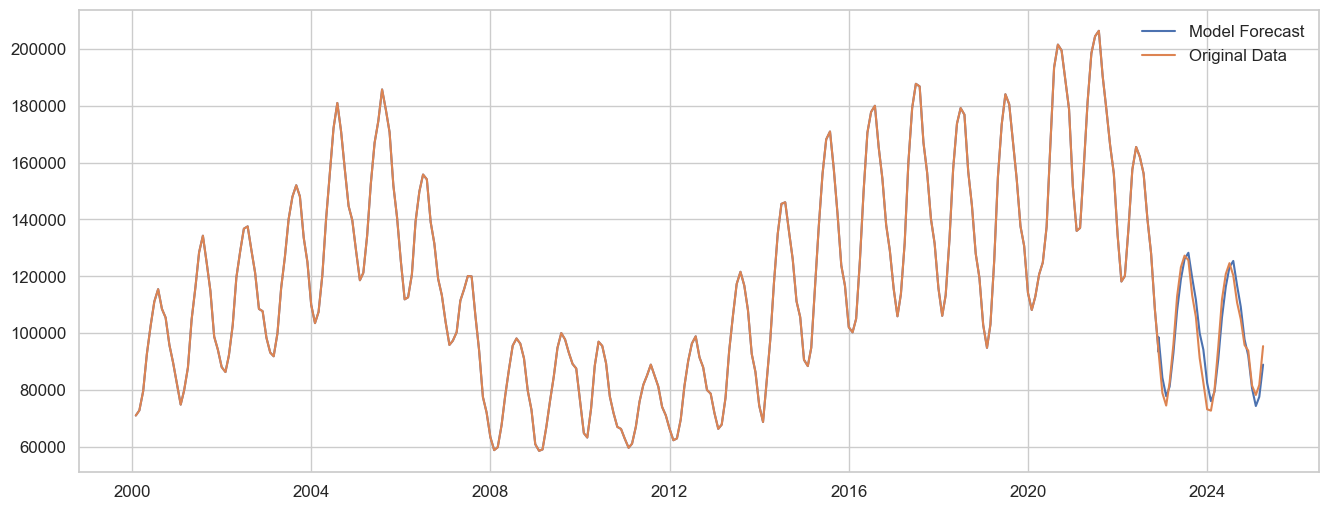

In [100]:
model_data = training_series.values[1:].reshape(275) - best_model.resid[1:]
model_data = pd.concat((model_data,preds_best))
plt.figure(figsize=(16,6));
plt.plot(model_data);
plt.plot(original_data[1:]);
plt.legend(['Model Forecast','Original Data']);

In [109]:
original_data

,SPCS20RPSNSA
observation_date,
2000-01-01,76273
2000-02-01,70994
2000-03-01,72795
2000-04-01,79561
2000-05-01,92584
...,...
2024-12-01,93822
2025-01-01,81549
2025-02-01,78228


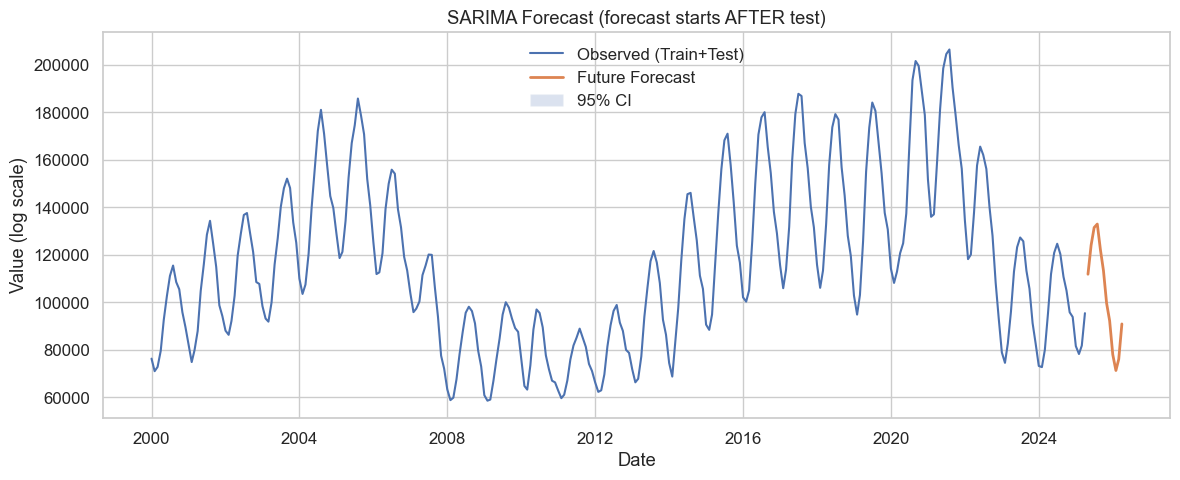

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- 0) Make sure your index has a proper freq (fixes the "<MonthBegin> vs None" error) ---
y = original_data.copy()
if y.index.freq is None:
    y = y.asfreq(pd.infer_freq(y.index))  # e.g., 'MS' or 'M'

res_full = best_model.apply(y)


fcst = res_full.get_forecast(steps=H)
fcst_mean = fcst.predicted_mean
fcst_ci   = fcst.conf_int()


plt.figure(figsize=(12,5))
plt.plot(y, label="Observed (Train+Test)")
plt.plot(fcst_mean.index, fcst_mean, label="Future Forecast", linewidth=2)

# confidence band
plt.fill_between(
    fcst_ci.index, fcst_ci.iloc[:, 0], fcst_ci.iloc[:, 1],
    alpha=0.2, label="95% CI"
)

plt.title("SARIMA Forecast (forecast starts AFTER test)")
plt.xlabel("Date"); plt.ylabel("Value (log scale)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [112]:
tests_score = []
trains_score = []
models_order = []
models_aic = []

for model in models:
    if model.aic < -1000:
        model_order = "ar:" + str(model.model_orders['ar']) + " ma:" + str(model.model_orders['ma']) + " s_ar:" + str(int(model.model_orders['seasonal_ar']/12)) + " s_ma:" + str(int(model.model_orders['seasonal_ma']/12))
        models_order.append(model_order)
        models_aic.append(model.aic)
        train_forecasts = training_series.values[1:].reshape(275) - model.resid[1:]
        train_mae = mean_absolute_error(training_data[1:], train_forecasts)
        trains_score.append(np.round(train_mae,3))
        preds=np.exp(model.predict(start=test_start_date, end='2025-04-01', dynamic=True, typ='levels'))    

        test_mape = mean_abs_pct_error(test_data,preds)
        tests_score.append(np.round(test_mape,3))
        
model_properties = {'aic':models_aic, 'model_order':models_order, 'train_score': trains_score, 'test_score':tests_score}    

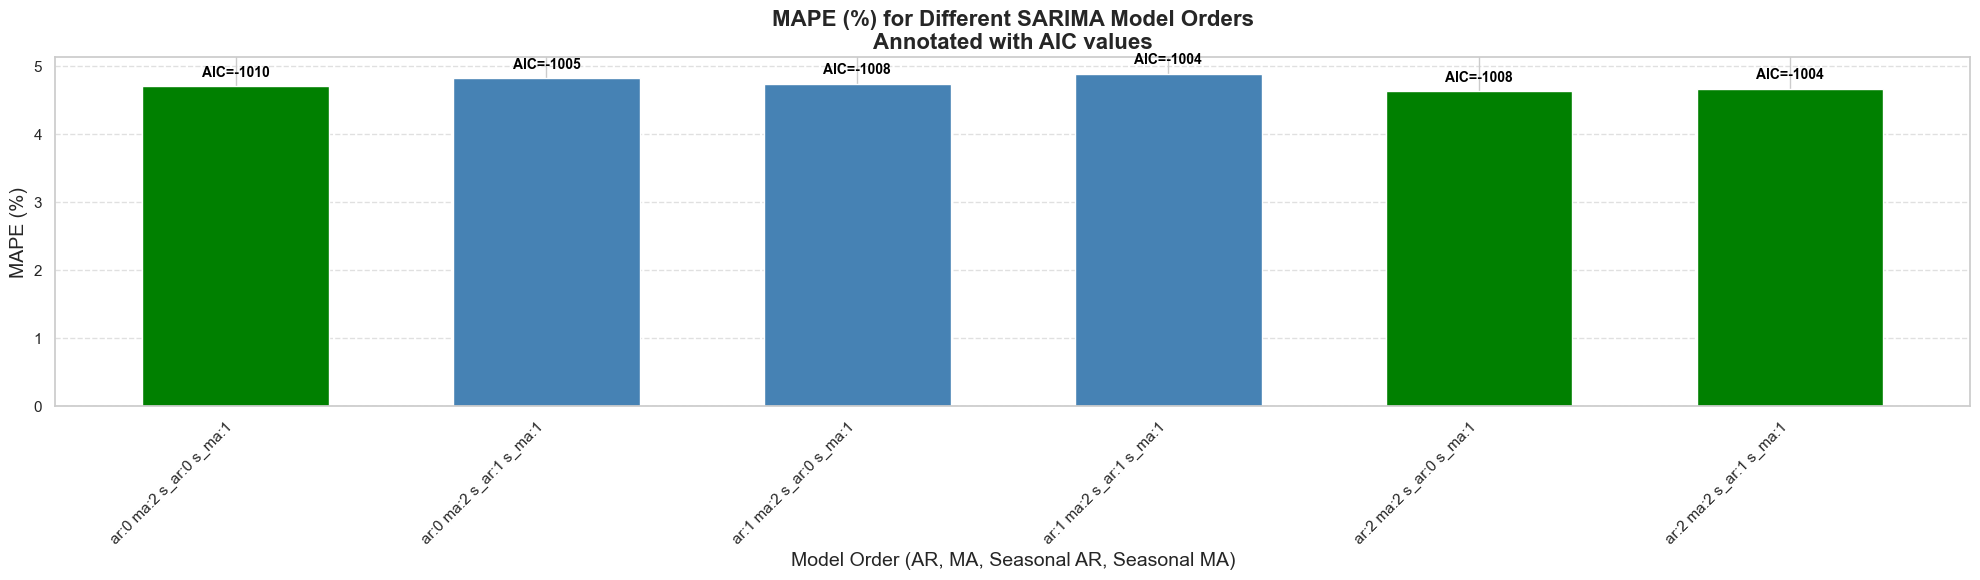

In [113]:
colors = ['green' if x < 4.71 else 'steelblue' for x in model_properties['test_score']]

plt.figure(figsize=(20, 6))
bars = plt.bar(model_properties['model_order'], model_properties['test_score'], color=colors, width=0.6)


plt.xlabel('Model Order (AR, MA, Seasonal AR, Seasonal MA)', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=14)
plt.title('MAPE (%) for Different SARIMA Model Orders\nAnnotated with AIC values', fontsize=16, fontweight='bold')

for i, (bar, aic_val) in enumerate(zip(bars, model_properties['aic'])):
    height = bar.get_height()
    plt.annotate(f'AIC={int(aic_val)}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 fontsize=10, color='black', fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [114]:
agile_model = SARIMAX(endog=log_transformed_data,order=(2,1,2), seasonal_order=(1,1,2,12), enforce_invertibility=False).fit()
agile_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       SPCS20RPSNSA   No. Observations:                  276
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 545.201
Date:                            Sun, 09 Nov 2025   AIC                          -1074.402
Time:                                    16:16:00   BIC                          -1045.824
Sample:                                01-01-2000   HQIC                         -1062.917
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2129      0.138      1.541      0.123      -0.058       0.484
ar.L2         -0.2195      0.110     -2.003      0.045      -0.434      -0.005
ma.L1          0.4457      0.130      3.437      0.001       0.192       0.700
ma.L2          0.5641      0.053     10.611      0.000       0.460       0.668
ar.S.L12      -0.3417      0.375     -0.910      0.363      -1.077       0.394
ma.S.L12      -0.4077      0.377     -1.082      0.279      -1.146       0.331
ma.S.L24      -0.4475      0.305     -1.468      0.142      -1.045       0.150
sigma2         0.0009   5.86e-05     14.712      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               243.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             1.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

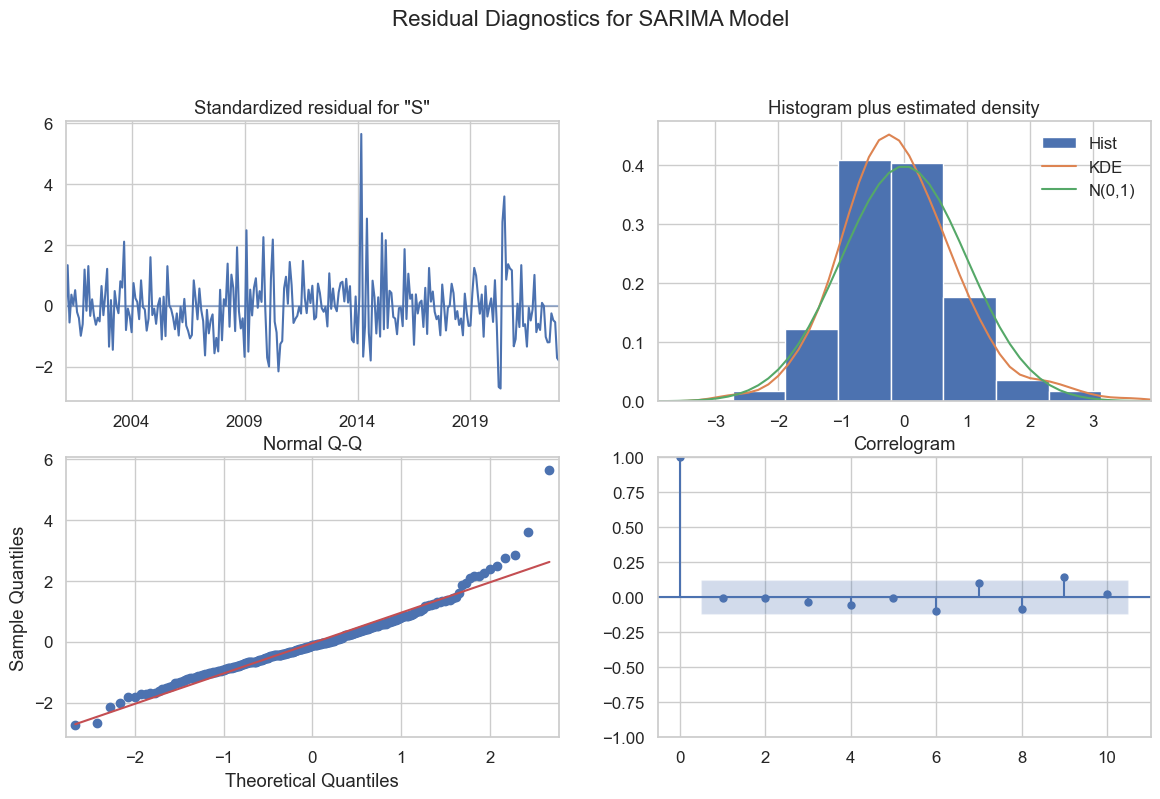

In [115]:
agile_model.plot_diagnostics(figsize=(14, 8));
plt.suptitle('Residual Diagnostics for SARIMA Model', fontsize=16, y=1.02);

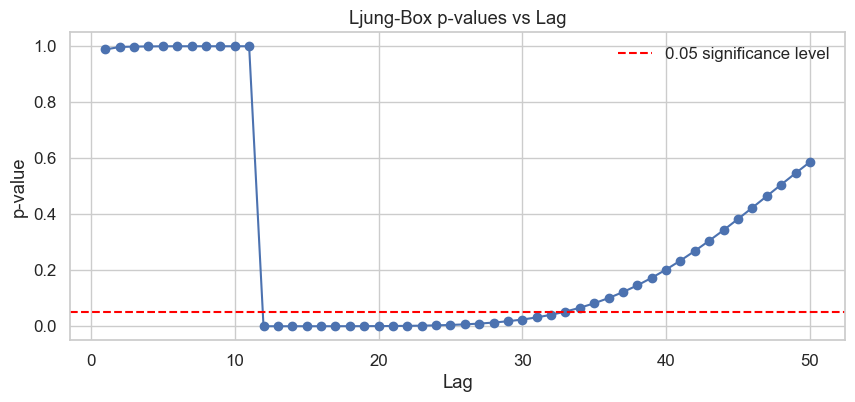

In [116]:
import matplotlib.pyplot as plt

# Run Ljung-Box test up to 50 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(agile_model.resid, lags=50, return_df=True)

# Plot p-values
plt.figure(figsize=(10, 4))
plt.plot(lb_result.index, lb_result['lb_pvalue'], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung-Box p-values vs Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mase_scale(y, m=1):
    """Mean absolute seasonal difference for MASE denominator."""
    y = np.asarray(y, dtype=float)
    if m <= 0 or len(y) <= m:
        diffs = np.abs(np.diff(y))
    else:
        diffs = np.abs(y[m:] - y[:-m])
    return float(np.mean(diffs)) if len(diffs) else np.nan

def rolling_sarima_forecast(
    y: pd.Series,
    order, seasonal_order,
    initial_train_size: int,
    horizon: int = 1,
    refit: bool = True,
    fixed_window: bool = False,
    alpha: float = 0.05,
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend=None,
):
    """
    Rolling-origin evaluation for SARIMA.
    Parameters
    ----------
    y : pd.Series
        Full series (train + test). DateTimeIndex preferred.
    order : tuple
        (p,d,q)
    seasonal_order : tuple
        (P,D,Q,s) or (0,0,0,0) if nonseasonal
    initial_train_size : int
        End index (exclusive) of the first training window
    horizon : int
        Steps ahead to forecast from each origin (uses last step for scoring)
    refit : bool
        If True, refit SARIMA each origin (expanding or fixed window).
        If False, keep params fixed and Kalman-update via .extend().
    fixed_window : bool
        If True, keep training window size constant; else expanding window.
    alpha : float
        1 - nominal coverage for prediction intervals.
    """
    assert initial_train_size >= 1 and initial_train_size < len(y), "Bad initial_train_size"
    idx = y.index
    preds, lower, upper, actuals, origins = [], [], [], [], []

    # MASE denominator from the initial training block (Hyndman/Koehler)
    s = seasonal_order[3] if seasonal_order and len(seasonal_order) == 4 else 1
    mase_den = mase_scale(y.iloc[:initial_train_size].values, m=max(1, s))
    if not np.isfinite(mase_den) or mase_den == 0:
        mase_den = 1e-12  # safe fallback

    # Optional base fit for refit=False (re-use params; Kalman-updated states)
    base_res = None
    if not refit:
        base_res = SARIMAX(
            y.iloc[:initial_train_size],
            order=order, seasonal_order=seasonal_order, trend=trend,
            enforce_stationarity=enforce_stationarity,
            enforce_invertibility=enforce_invertibility
        ).fit(disp=False)

    t = initial_train_size
    while t + horizon <= len(y):
        # choose training slice
        if refit:
            if fixed_window:
                start = max(0, t - initial_train_size)
                train_slice = y.iloc[start:t]
            else:
                train_slice = y.iloc[:t]

            res = SARIMAX(
                train_slice,
                order=order, seasonal_order=seasonal_order, trend=trend,
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility
            ).fit(disp=False)

            fc = res.get_forecast(steps=horizon)
        else:
            # Keep parameters fixed, update states with new data up to t
            res = base_res
            endog_len = len(res.model.endog)
            if endog_len < t:
                # extend with the new block y[endog_len:t]
                res = res.extend(y.iloc[endog_len:t])
                base_res = res
            fc = res.get_forecast(steps=horizon)

        # last step of horizon is used for scoring
        mean_fc = fc.predicted_mean.iloc[-1]

        # Robust CI extraction (columns are usually ['lower y', 'upper y'])
        ci = fc.conf_int(alpha=alpha)
        lo = float(ci.iloc[-1, 0])
        hi = float(ci.iloc[-1, 1])

        actual = float(y.iloc[t + horizon - 1])

        preds.append(float(mean_fc))
        lower.append(lo)
        upper.append(hi)
        actuals.append(actual)
        origins.append(idx[t + horizon - 1])

        t += 1

    out = pd.DataFrame({
        "y_true": actuals,
        "y_pred": preds,
        "pi_lower": lower,
        "pi_upper": upper,
    }, index=pd.Index(origins, name=y.index.name))

    # Metrics
    mae = mean_absolute_error(out.y_true, out.y_pred)
    rmse = np.sqrt(mean_squared_error(out.y_true, out.y_pred))


    eps = 1e-12
    mape = np.mean(
        np.abs((out.y_true - out.y_pred) / np.maximum(np.abs(out.y_true), eps))
    ) * 100.0
    smape = 100.0 * np.mean(
        2.0 * np.abs(out.y_pred - out.y_true) / np.maximum(np.abs(out.y_pred) + np.abs(out.y_true), eps)
    )

    mase = mae / (mase_den if mase_den > 0 else eps)
    coverage = np.mean((out.y_true >= out.pi_lower) & (out.y_true <= out.pi_upper))
    avg_pi_width = np.mean(out.pi_upper - out.pi_lower)

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape,
        "sMAPE_%": smape,
        "MASE": mase,
        "PI_coverage": coverage,
        "Avg_PI_width": avg_pi_width,
        "alpha": alpha,
        "season_length_for_MASE": s,
        "horizon": horizon,
        "refit": refit,
        "fixed_window": fixed_window
    }
    return out, metrics


{'MAE': 2731.4726776205944, 'RMSE': np.float64(3520.4553705309227), 'MAPE_%': np.float64(3.016327762576132), 'sMAPE_%': np.float64(3.069535717108427), 'MASE': 0.17691336598217416, 'PI_coverage': np.float64(0.9642857142857143), 'Avg_PI_width': np.float64(19236.518688423883), 'alpha': 0.05, 'season_length_for_MASE': 12, 'horizon': 1, 'refit': True, 'fixed_window': False}
                   y_true        y_pred      pi_lower       pi_upper
observation_date                                                    
2024-12-01        93822.0  88437.051493  78976.531360   97897.571627
2025-01-01        81549.0  86816.042575  77365.634576   96266.450574
2025-02-01        78228.0  77515.526335  68013.544998   87017.507672
2025-03-01        81755.0  82538.295227  73059.300039   92017.290414
2025-04-01        95416.0  96883.772240  87418.046856  106349.497623


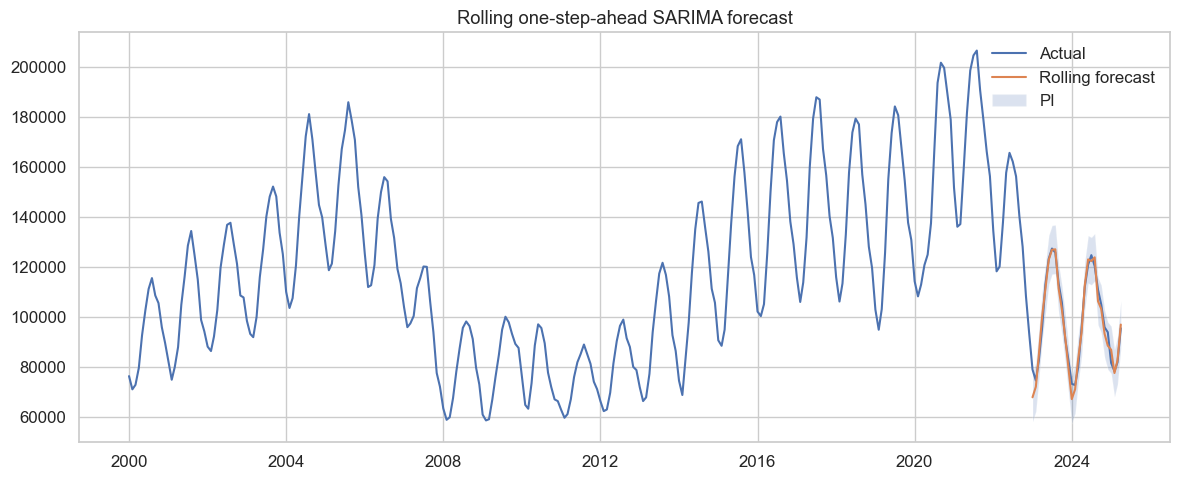

In [124]:
# Suppose these exist:
# y: pd.Series (full data)
# best_model: fitted SARIMAXResults on the training portion
initial_train_size = len(best_model.model.endog)   # use the same training span you fit on

# Pull the specification used by your fitted model
order = best_model.model.order
seasonal_order = best_model.model.seasonal_order
trend = getattr(best_model.model, "trend", None)  # safe in case not set

# Run expanding-window rolling forecast across the entire series
out, metrics = rolling_sarima_forecast(
    y=y,
    order=order,
    seasonal_order=seasonal_order,
    initial_train_size=initial_train_size,
    horizon=1,                 # one-step-ahead
    refit=True,                # safest/most accurate; set to False to keep params fixed
    fixed_window=False,        # expanding window
    alpha=0.05,
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend=trend
)

print(metrics)
# Peek at the first few rows of forecasts vs actuals
print(out.tail(5))

# Optional quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y.index, y.values, label="Actual")
plt.plot(out.index, out["y_pred"], label="Rolling forecast")
plt.fill_between(out.index, out["pi_lower"], out["pi_upper"], alpha=0.2, label="PI")
plt.title("Rolling one-step-ahead SARIMA forecast")
plt.legend()
plt.tight_layout()
plt.show()


## What is Rolling forecast and why its better than just splitting in train and test in time series?
### Ans:- 

Imagine your time series is:

y1, y2, y3, y4, y5, y6, y7, y8, y9, y10


Suppose:

Training window ends at y5

You want 1–step ahead rolling forecast

Then rolling works like this:

Step 1 (Origin = y5)

Data available:

y1, y2, y3, y4, y5


You fit your model on these and predict:

Forecast for y6


Compare forecast to actual y6.

Step 2 (Origin = y6)

Now you pretend a month passed.
You now know:

y1, y2, y3, y4, y5, y6


You fit (or update) using this bigger window and predict:

Forecast for y7


Compare forecast to actual y7.

Step 3 (Origin = y7)

You now know:

y1, y2, y3, y4, y5, y6, y7


You forecast:

Forecast for y8


Compare to y8.

You continue until you exhaust the data.

This gives a series of out-of-sample forecasts:

ŷ6, ŷ7, ŷ8, ŷ9, ŷ10   (predictions)
y6, y7, y8, y9, y10   (actuals)


#### 1. A single train-test split tests the model only once

If you just split like this:

Train: y1 ... y80
Test:  y81 ... y100


You only check:

how the model performs at one point in time

on one test window

with one set of model parameters

If the model does badly or well here, you don’t know if it's luck... or real skill.

✅ 2. Rolling forecast tests the model many times, not once

With rolling you do:

Train → forecast y(k)  
Train → forecast y(k+1)  
Train → forecast y(k+2)  
... till end of data


You’re repeatedly:

refitting (or updating) the model

forecasting with new information

evaluating performance under constantly changing conditions

This gives you dozens or even hundreds of forecast errors.

More forecast errors = more reliable evaluation.

✅ 3. Rolling respects the temporal order in a realistic way

In real forecasting:

You always fit on past

Forecast future

Then get new data

Then refit/update

Then forecast again

A single train-test split does not simulate this properly.

Rolling forecast DOES.

It mimics how forecasting works in the real world.

✅ 4. Rolling detects model drift

Models break over time.

A single train-test split cannot detect:

regime shifts

changes in seasonality

structural breaks

volatility bursts

demand patterns changing

Rolling forecast will show:

errors suddenly rise → regime changed


You get a time-series of forecast errors, not a single number.

✅ 5. Rolling gives you distributional understanding (not just one number)

You get:

RMSE over time

MAE over time

Prediction interval coverage over time

Bias over time

Error spikes

Worst-case errors

Stability of coefficients (if refit=True)

A single split gives you one RMSE.
That’s not insight. That’s a coin toss.

✅ 6. Rolling reduces overfitting risk

Fitting once and testing once is extremely sensitive.

Example:
If the test period is unusually easy, RMSE looks great.
If the test period is unusually hard, RMSE looks terrible.

Rolling balances this over many forecasting points.

✅ 7. Rolling allows scenario analysis

You can compare:

expanding window vs sliding window

refit=True vs refit=False

horizon=1 vs horizon=3

different ARIMA/SARIMA configurations

machine learning vs classical models

All with the same rolling framework.

A single test split can’t do that effectively.

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0469 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0229 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - learning

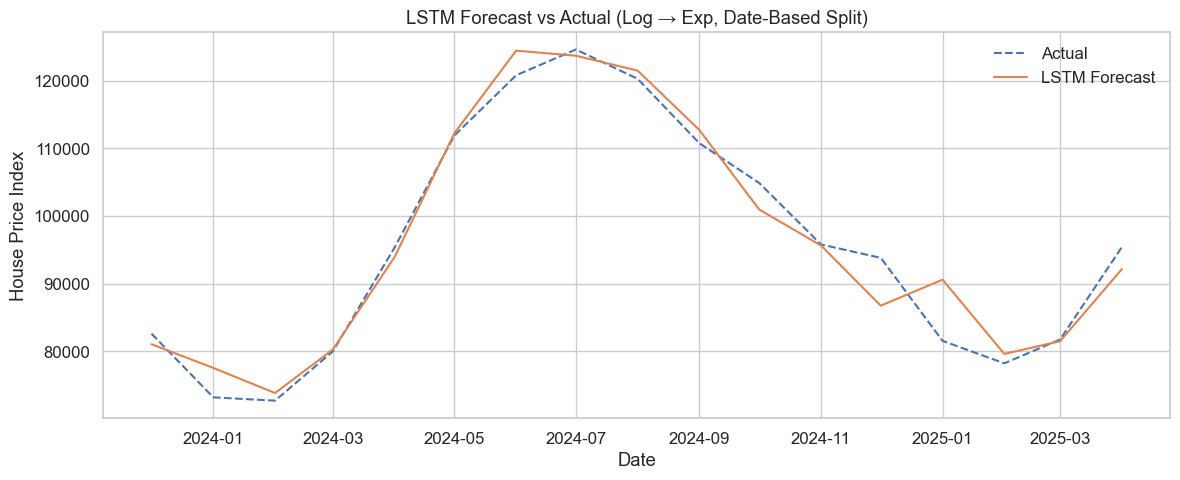

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Load and log-transform ---
df = pd.read_csv("SPCS20RPSNSA.csv", parse_dates=['observation_date'], index_col='observation_date')
original_data = df.copy()
original_data['SPCS20RPSNSA'] = np.log(original_data['SPCS20RPSNSA'].astype('float32'))  # log transform

# --- Date-based split ---
test_start_date = '2022-12-01'
training_data = original_data[:test_start_date]
test_data = original_data[test_start_date:]

training_series = training_data['SPCS20RPSNSA']
test_series = test_data['SPCS20RPSNSA']

# --- Scaling ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

# --- TimeSeriesGenerator ---
lookback = 12
train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=lookback, batch_size=1)
test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=lookback, batch_size=1)

# --- LSTM Model ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(lookback, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()



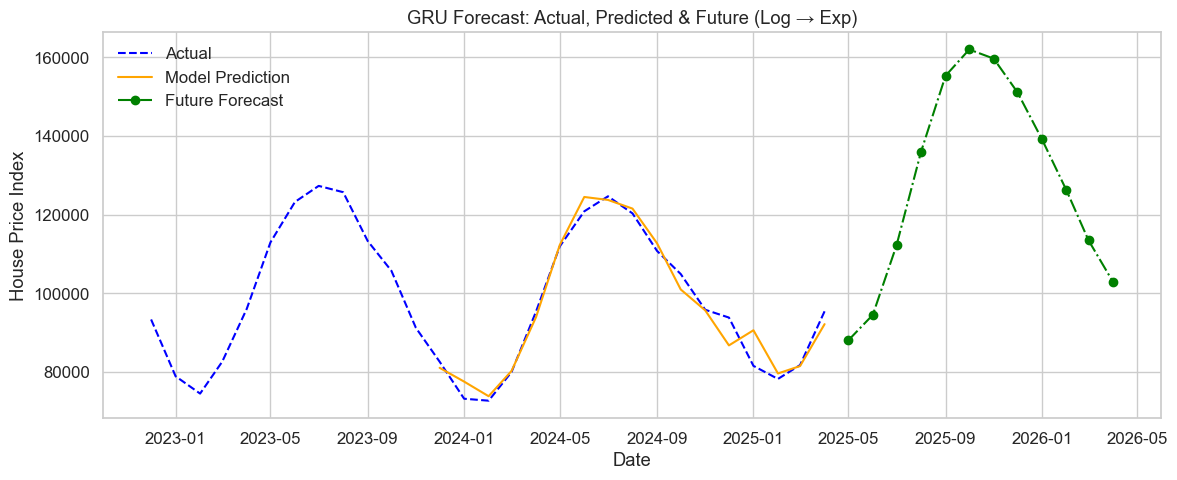

In [130]:
# --- Forecast Future Steps ---
n_future = 12  # months to forecast
forecast_input = train_scaled[-lookback:].reshape(1, lookback, 1)  # last window
forecast_scaled = []

for _ in range(n_future):
    next_pred = model.predict(forecast_input, verbose=0)[0]
    forecast_scaled.append(next_pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[next_pred]], axis=1)

# --- Inverse transform and exponentiate forecast ---
forecast_log = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))
forecast = np.exp(forecast_log)

# --- Fix: ensure continuous forecast dates ---
last_date = test_series.index[-1]
start_of_next_month = last_date + pd.offsets.MonthBegin(1)
forecast_dates = pd.date_range(start=start_of_next_month, periods=n_future, freq='MS')

# --- Fix: exponentiate actual test series ---
actual_values = np.exp(test_series.values)
dates = test_series.index[lookback:]  # prediction-aligned dates

# --- Plot everything cleanly ---
plt.figure(figsize=(12, 5))

# Actual values
plt.plot(test_series.index, actual_values, label='Actual', linestyle='--', color='blue')

# Model predictions
plt.plot(dates, y_pred, label='Model Prediction', linestyle='-', color='orange')

# Forecast
plt.plot(forecast_dates, forecast, label='Future Forecast', linestyle='-.', marker='o', color='green')

plt.title("GRU Forecast: Actual, Predicted & Future (Log → Exp)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0310 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023 - learning

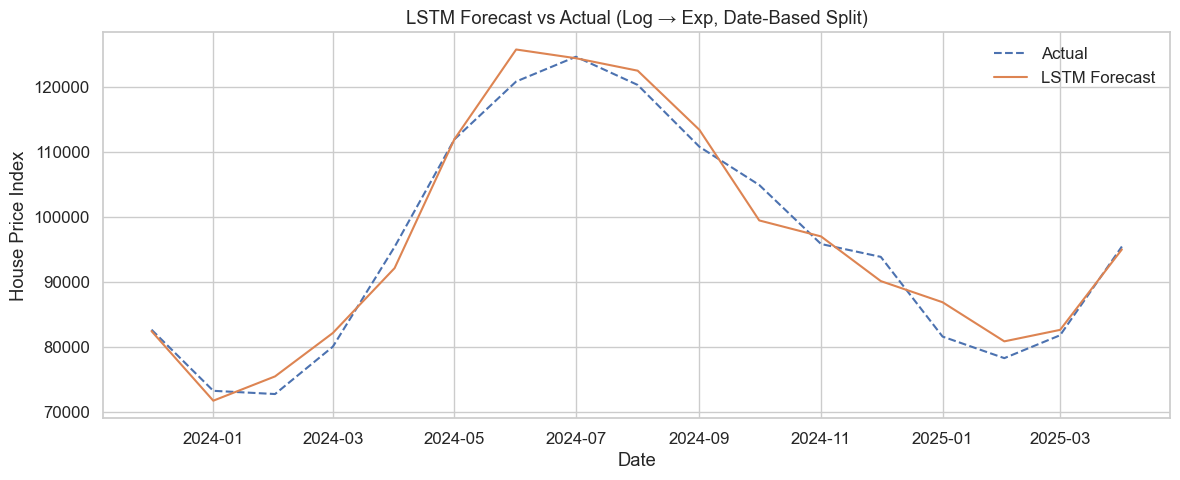

In [131]:
# --- LSTM Model ---
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(64, activation='relu', input_shape=(lookback, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\sayan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1131 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0258 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0099 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0022 - learning

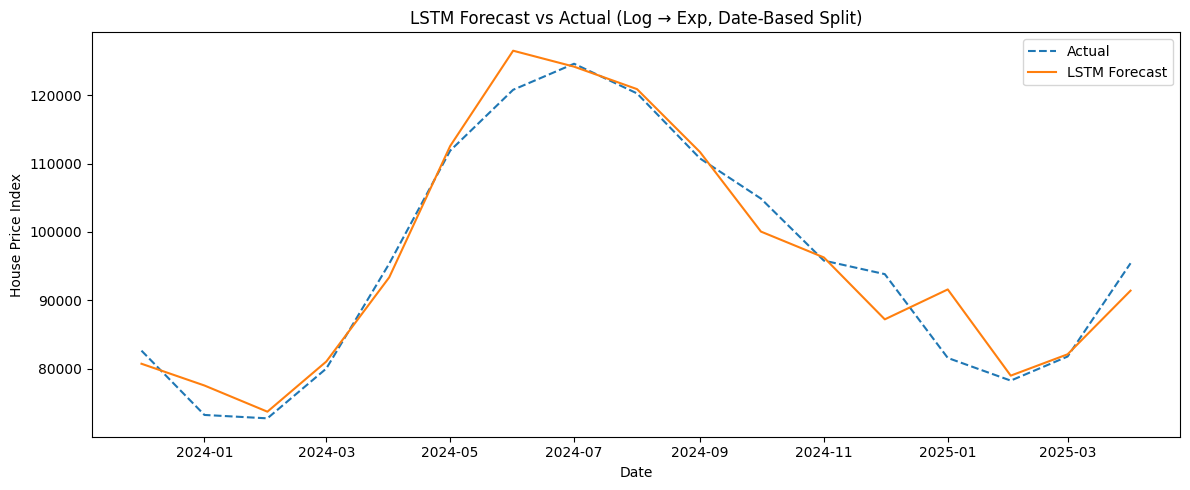

In [7]:
# --- LSTM Model ---
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
    GRU(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()

1. Lookback (Sequence Length)

lookback = 12

This means: your LSTM will look at the previous 12 time steps (months, in your case) to predict the next value.

It's like saying: "Based on the past 12 months of prices, predict the next month's price."

test_start_date = '2022-12-01'

training_data = original_data[:test_start_date]

test_data = original_data[test_start_date:]

Training data: from the start of your dataset up to (but not including) Dec 2022

Testing data: from Dec 2022 onward

The target column: 'SPCS20RPSNSA', which has been log-transformed

Suppose your data is like this (after scaling):
[t0, t1, t2, ..., t13]

Then:

First sample: X = [t0..t11], y = t12

Second sample: X = [t1..t12], y = t13

... and so on

So:

Training samples: len(training_data) - lookback

Test samples: len(test_data) - lookback

In [39]:
## sarima is working slightly better than lstm , the reason lies here the data is small so DL model underperforms though it worked surprisingly well considering the dataset size

# Implementation of Facebook - Prophet

#   Prepare the data for Prophet
###  Prophet requires:

#### a column named "ds" for dates

#### column named "y" for the target 

In [51]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Create a Prophet-compatible DataFrame
df_prophet = original_data.copy()
df_prophet = np.log(df_prophet)
df_prophet = df_prophet.reset_index().rename(columns={"observation_date": "ds", "SPCS20RPSNSA": "y"})

# Split into train/test
split_date = "2022-12-01"
train_df = df_prophet[df_prophet["ds"] <= split_date]
test_df = df_prophet[df_prophet["ds"] > split_date]


In [52]:
# Initialize and fit the model
prophet = Prophet()
prophet.fit(train_df)

# Create future dataframe (same length as test set)
future = prophet.make_future_dataframe(periods=len(test_df), freq='MS')

# Predict
forecast = prophet.predict(future)

# Extract predictions for test period
predicted_log = forecast.set_index("ds").loc[test_df["ds"], "yhat"]
actual_log = test_df.set_index("ds")["y"]


09:34:16 - cmdstanpy - INFO - Chain [1] start processing
09:34:16 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Inverse transform (from log scale back to original scale)
actual_orig = np.exp(actual_log)
predicted_orig = np.exp(predicted_log)

# Evaluation on original scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(actual_orig, predicted_orig))
mae = mean_absolute_error(actual_orig, predicted_orig)
r2 = r2_score(actual_orig, predicted_orig)

print(f"\n Prophet Forecast Evaluation (Original Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")




 Prophet Forecast Evaluation (Original Scale):
RMSE: 0.41
MAE: 0.41
R² Score: -4.0862


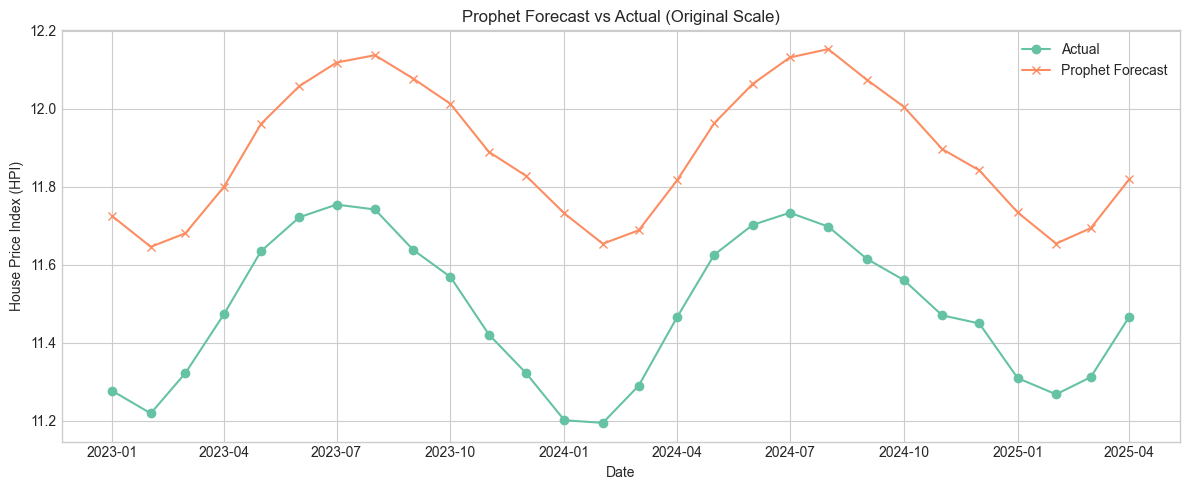

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(actual_orig.index, actual_orig, label='Actual', marker='o')
plt.plot(predicted_orig.index, predicted_orig, label='Prophet Forecast', marker='x')
plt.title("Prophet Forecast vs Actual (Original Scale)")
plt.xlabel("Date")
plt.ylabel("House Price Index (HPI)")
plt.legend()
plt.tight_layout()
plt.show()
